# Stick&Slip

On pose  les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\gamma = \frac{ \mu d_c}{b \sigma H}$$

On trouve :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\bar{\Psi}[e^{\varphi}] - \gamma(\bar{v_m}-1)) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

Avec l'adimensionnement suivant : $$\bar \Psi = L_b \cdot \Psi$$

$$\Psi : v \mapsto \mathcal{K} * v$$

En définissant le noyau $\mathcal{K}$ par sa transformée de Fourier :

$$\mathcal{F}(\mathcal{K}) : k \mapsto |k| \frac{1+e^{-4|k|H}}{1-e^{-4|k|H}} = \frac{|k|}{\tanh(2|k|H)} $$

In [27]:
import numpy as np
import matplotlib.pyplot as plt

##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a1 = 2e-3
a2 = 3e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

deltaX = int(Lb/4)
N = 50000
I = 2**8
L = I * deltaX
H = 2*L
h = 1e-2

d = L//8
K1 = (L//2-d)//deltaX
K2 = (L//2+d)//deltaX

alpha1 = a1/b 
alpha2 = a2/b
beta = eta*v0/(b*sigma) #=6e-08
gamma = mu*dc/(b*sigma*H)

##Calcul du gradient de la transformée de Hilbert (cf. doc)
def noyau(freq,H) :
    pos = freq==0 #on localise la position des zéros
    freq[pos] = 1 #On remplace les zéros par des non-zéros (1 par exemple)
    c = np.abs(freq)
    freq = c/np.tanh(2*H*c) #on applique l'opération (sans rencontrer de zéros donc)
    freq[pos] = 0 #on met des zéros aux positions des zéros du tableau de départ
    return freq

def Psi(f, deltaX, H) :
    F=np.fft.fft(f)
    freq=np.fft.fftfreq(len(f),deltaX)*2*np.pi
    K = noyau(freq, H)
    F=K*F
    psi=np.fft.ifft(F)
    return psi.real*Lb

In [28]:
def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K + 1
        s = (tol / (2 * erreur))**0.25
        print(erreur)
        if erreur < tol:
            return ykk, s*h
        if s*h < dtmin:
            return ykk, h
        h = s*h
    if K==30 and erreur == tol:
        raise ValueError("Trop d'iterations")
    return ykk, h

In [29]:
def F(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    phidot = (v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1)))/(alpha1+beta*v)
    nudot = 1/theta - v
    return np.array([phidot, nudot])

def G(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    D = v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1))
    phid1 = D/(alpha1 + beta*v)
    phid2 = D/(alpha2 + beta*v)
    phidot = np.concatenate((phid1[0:K1], phid2[K1:K2+1], phid1[K2+1:]))
    nudot = 1/theta - v
    return np.array([phidot, nudot])

In [30]:
x = np.arange(-L//2, L//2 + 1, deltaX)
temps = np.array([0])
amp = 100
CI = amp*np.ones(len(x))

phik = np.log(CI)
nuk = np.log(1/CI)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    res = RKF(G, yk, h)
    yk = res[0]
    h = res[1]
    temps = np.concatenate((temps, [temps[n]+h]))
    Phi.append(yk[0])
    Nu.append(yk[1])

1.17812302026004
2.6674942108828516e-14
2.6478822791465673e-10
3.206330298828584e-11
4.8149908066835374e-11
4.2530348998771904e-11
4.395774445520668e-11
4.3358023973725625e-11
4.3374280570665775e-11
4.321722724870874e-11
4.312675729189043e-11
4.3055628658241704e-11
4.3031867933166965e-11
4.3071909763689295e-11
4.3230660367963026e-11
4.3538514921266236e-11
4.406104429951218e-11
4.483536061332004e-11
4.584549927224929e-11
4.699603741900287e-11
4.81420469723258e-11
4.9130172398721106e-11
4.9885928728619913e-11
5.0413209390824e-11
5.0754744445871506e-11
5.0963787707491675e-11
5.1092781120873025e-11
5.115604653893662e-11
5.1192707867861625e-11
5.120748391368507e-11
5.120345861098715e-11
5.119183845661862e-11
5.11737402949665e-11
5.115705206518397e-11
5.113113960474008e-11
5.110982167251495e-11
5.1077869320283335e-11
5.1055262239343096e-11
5.102393593106441e-11
5.099776457292532e-11
5.0965964026251206e-11
5.0938265498076893e-11
5.090718100588783e-11
5.087483881564257e-11
5.08457846152985e-11

5.0790659245389907e-11
5.066959637691294e-11
5.0548426304538025e-11
5.0424453816229954e-11
5.029457076187833e-11
5.016469665496076e-11
5.002632098520955e-11
4.9883161708459614e-11
4.9730904279515745e-11
4.9569816109481846e-11
4.939772757967862e-11
4.920990071677248e-11
4.900818377386073e-11
4.8784426958444884e-11
4.8538342764638456e-11
4.8267637186795546e-11
4.796481675556634e-11
4.7631793563258074e-11
4.727517221665872e-11
4.690874786423482e-11
4.658393635939821e-11
4.642115320433158e-11
4.666420075267625e-11
4.7735427987142045e-11
4.998915352951678e-11
5.302825824502278e-11
5.550001390563251e-11
5.658408715126209e-11
5.6636492489365086e-11
5.6225626857883274e-11
5.568474118747164e-11
5.514880645637114e-11
5.466011783722453e-11
5.422930972741776e-11
5.385367660703558e-11
5.352386182368737e-11
5.3234852221299154e-11
5.2978042175199e-11
5.275081415319481e-11
5.2544426237214426e-11
5.2358647532145355e-11
5.21878959633284e-11
5.203053807669581e-11
5.1888506451299394e-11
5.175082207231312e

5.070428439581645e-11
5.067952567975212e-11
5.0647926766973864e-11
5.062287158206527e-11
5.0595348924157e-11
5.056654843469052e-11
5.053961305381761e-11
5.051202853593198e-11
5.048333532601157e-11
5.045372627194677e-11
5.042565096577803e-11
5.039635713788668e-11
5.036391992880561e-11
5.0337207775369555e-11
5.03010671450179e-11
5.027034693837743e-11
5.023724772954822e-11
5.020473935852957e-11
5.016847365690256e-11
5.012829696113918e-11
5.008995861363542e-11
5.0048609822225907e-11
5.000394592690081e-11
4.996139547939961e-11
4.990678756038652e-11
4.9857718759440786e-11
4.9797534376905e-11
4.974009513830282e-11
4.966955900722457e-11
4.960016682102788e-11
4.9519592989616174e-11
4.94307661410536e-11
4.933869945735644e-11
4.92328584254814e-11
4.91224279508392e-11
4.8997581404781115e-11
4.887296225017272e-11
4.8732501525821576e-11
4.860806466661861e-11
4.849270868971219e-11
4.843043896669732e-11
4.845748011662594e-11
4.8658040570471904e-11
4.9133178844666973e-11
4.9994673373781997e-11
5.127642

5.594776321430935e-11
5.588034805741943e-11
5.5809043171366635e-11
5.5734962578647185e-11
5.566902372151632e-11
5.559245033352287e-11
5.551740674064985e-11
5.544791808109362e-11
5.537145677373482e-11
5.529487073322579e-11
5.522342182446664e-11
5.514659058068157e-11
5.5066247413999976e-11
5.4998764664553177e-11
5.4916909593682785e-11
5.4842361854294786e-11
5.4767074373592246e-11
5.469073634635753e-11
5.46178444886068e-11
5.454334363191664e-11
5.447420149678863e-11
5.439965320528252e-11
5.4337589288719846e-11
5.427013511077762e-11
5.420785105131066e-11
5.415547126520882e-11
5.410279443116035e-11
5.4052461432680745e-11
5.4012400851728695e-11
5.397941493092369e-11
5.395406219838017e-11
5.39414300387258e-11
5.3933953326647306e-11
5.3940633361821706e-11
5.3965490654887696e-11
5.400298225082744e-11
5.4055828046584874e-11
5.412690553654925e-11
5.420856911101476e-11
5.430896175048035e-11
5.441983473398138e-11
5.4530984627111114e-11
5.4646624592217675e-11
5.475038132911572e-11
5.4842087941866624

4.9021258561807435e-11
4.903142586939153e-11
4.9028715224585985e-11
4.903319542220569e-11
4.90313159133282e-11
4.9024816427503494e-11
4.901853144978873e-11
4.902001822564373e-11
4.899121716546051e-11
4.899446275658543e-11
4.896945210565262e-11
4.896073363659833e-11
4.89221633395427e-11
4.890290777087598e-11
4.8887829456709815e-11
4.884925987913966e-11
4.883314048616982e-11
4.880310443890608e-11
4.878848519677084e-11
4.87636373495585e-11
4.876493524311083e-11
4.8767722634668355e-11
4.8788803020281106e-11
4.882536056341619e-11
4.889462576281776e-11
4.89950431648827e-11
4.911653659708414e-11
4.93033403943433e-11
4.952278816076157e-11
4.9813168528890114e-11
5.013673497370989e-11
5.0477190600366935e-11
5.078602088675274e-11
5.093828610691296e-11
5.087060105694998e-11
5.047642296260102e-11
4.967737786270451e-11
4.842529682637124e-11
4.671338507161401e-11
4.4829198144276304e-11
4.506317635005861e-11
5.570122632467836e-11
7.19060641136968e-11
6.963727542662086e-11
6.434039025592542e-11
6.10213

5.276640547626328e-11
5.233562013343913e-11
5.195322815195711e-11
5.1607638686870124e-11
5.1313601959826914e-11
5.10500761236131e-11
5.081264772270352e-11
5.0602606409974703e-11
5.042007978655362e-11
5.025318784419757e-11
5.0109582747143185e-11
4.997495420876177e-11
4.9862890358528025e-11
4.975279591636054e-11
4.966312181898542e-11
4.957759933056418e-11
4.9504523488677675e-11
4.9433169588010545e-11
4.938323147199501e-11
4.932026594483195e-11
4.927888972438937e-11
4.923033175683945e-11
4.9193054557320956e-11
4.9157453140282424e-11
4.9127237694143174e-11
4.909102977599346e-11
4.9071182951625194e-11
4.90475568642757e-11
4.9026206463847026e-11
4.9006842668013634e-11
4.89850880403644e-11
4.897825031364802e-11
4.894606478250608e-11
4.895164210722216e-11
4.8927363025900093e-11
4.8922290833107873e-11
4.8912420838119957e-11
4.890587476474593e-11
4.8891891487039684e-11
4.8891406890318717e-11
4.888452983229385e-11
4.8880204525823295e-11
4.887927930604475e-11
4.888109914674284e-11
4.88836015397718

5.117802545500442e-11
5.1095880204605267e-11
5.106119099528671e-11
5.101179661843498e-11
5.096541019133251e-11
5.090995244642523e-11
5.087132107505967e-11
5.081672667246898e-11
5.0752531047711965e-11
5.068568189880576e-11
5.0608531725971406e-11
5.053272792511659e-11
5.045833517431677e-11
5.0363208839278166e-11
5.0278616615517045e-11
5.018961535536276e-11
5.010675293907796e-11
5.000770632516339e-11
4.993525987492125e-11
4.984942459984836e-11
4.976227543485515e-11
4.968867419909481e-11
4.962046727748967e-11
4.954593877657711e-11
4.948759215078878e-11
4.941938807645817e-11
4.936076391318649e-11
4.931000818562631e-11
4.9257055223637067e-11
4.920764415679676e-11
4.916361610582653e-11
4.912257867496707e-11
4.908110275038205e-11
4.9045009236684926e-11
4.901287940206982e-11
4.8980773934043406e-11
4.895453552285707e-11
4.8921719742129774e-11
4.8901884401887454e-11
4.887228767650476e-11
4.885771470965505e-11
4.883130749157341e-11
4.882117388860088e-11
4.880073434713214e-11
4.8784730939333975e-11

5.0029102293548705e-11
5.017122551677562e-11
5.0405766041955953e-11
5.0745191040843066e-11
5.118152829957752e-11
5.16738310056002e-11
5.219552947709397e-11
5.2662318547492704e-11
5.303426447607473e-11
5.329784947909011e-11
5.344360249218859e-11
5.346833489342683e-11
5.343579634099372e-11
5.332538681457359e-11
5.3173177741995066e-11
5.301409382824821e-11
5.283090058834832e-11
5.2641021258658796e-11
5.246289926397729e-11
5.226006362232252e-11
5.210422871938287e-11
5.191281911392214e-11
5.1753245565344805e-11
5.159105263469233e-11
5.1436847991007385e-11
5.129805107777194e-11
5.115509970393778e-11
5.1017156322908546e-11
5.0890602316935425e-11
5.0770442473144486e-11
5.064816005003503e-11
5.053906512407979e-11
5.0433772184464185e-11
5.0328361349873094e-11
5.023072960933268e-11
5.012813783514104e-11
5.004918202337846e-11
4.9948399887615875e-11
4.98715712965562e-11
4.978212331928078e-11
4.970862854017333e-11
4.962739286948039e-11
4.955063215290292e-11
4.947509163818511e-11
4.941490594356192e-1

4.8467126950196694e-11
4.8407844100598456e-11
4.83870742605157e-11
4.834544249584546e-11
4.831076085646424e-11
4.828049851841e-11
4.824028522388815e-11
4.822815152350286e-11
4.8177184654611206e-11
4.8158757437948945e-11
4.813221927605175e-11
4.8100872876970714e-11
4.807905520550284e-11
4.80618938203792e-11
4.804341296476998e-11
4.802050450495931e-11
4.800119333510992e-11
4.800144209679987e-11
4.7977307085057174e-11
4.798178663406122e-11
4.796037274510015e-11
4.7974231368169945e-11
4.795388789288794e-11
4.7966792564871824e-11
4.796933628347284e-11
4.798793030822716e-11
4.805418277806606e-11
4.816974761687732e-11
4.841564700163475e-11
4.890441912113724e-11
4.9726035172713727e-11
5.09589430126733e-11
5.2555450788143376e-11
5.416446553737e-11
5.541947732745962e-11
5.613546111268223e-11
5.63583963627604e-11
5.627052226958098e-11
5.599809881600485e-11
5.564083824607167e-11
5.5259586690246955e-11
5.4876991706622486e-11
5.452279165477244e-11
5.417923440556718e-11
5.3874917572552343e-11
5.35582

4.4735547729831756e-11
4.463458178117503e-11
4.452415361224647e-11
4.442776014051593e-11
4.432282808944391e-11
4.42270005645314e-11
4.4125799534033773e-11
4.403927376465378e-11
4.3953733401385415e-11
4.3886808405048324e-11
4.38268768336259e-11
4.3788956279537484e-11
4.3771682453159056e-11
4.37897672517171e-11
4.383889496724342e-11
4.392494641072014e-11
4.406551522664322e-11
4.4240465923928294e-11
4.448876051378067e-11
4.476541667643742e-11
4.50904545349024e-11
4.54529557651105e-11
4.58351893300207e-11
4.621106702558507e-11
4.658433268414157e-11
4.6938351368463493e-11
4.7263420218764964e-11
4.754226104504565e-11
4.778441806864822e-11
4.799170709681659e-11
4.815389290431142e-11
4.829819825817546e-11
4.8408402258438455e-11
4.849386993047524e-11
4.856254568153567e-11
4.862641093569659e-11
4.8667202631019834e-11
4.869145814853779e-11
4.8729333393449e-11
4.875230355004729e-11
4.8759522630804837e-11
4.8774095148945904e-11
4.8784742340869216e-11
4.8792296911660175e-11
4.880610734786874e-11
4.8

5.333966472690401e-11
5.314144301653779e-11
5.29735887281616e-11
5.281672671598545e-11
5.264985198557939e-11
5.251092553236977e-11
5.236259019742007e-11
5.2239457376524784e-11
5.2105875137955947e-11
5.1998140306676185e-11
5.187042209706045e-11
5.176004673792996e-11
5.1652493861938046e-11
5.155486661991509e-11
5.1456517056075163e-11
5.1350458955838704e-11
5.1259124452391724e-11
5.11708304211864e-11
5.1085626118907106e-11
5.099210377896574e-11
5.0916515937428144e-11
5.082613263309766e-11
5.076194506842326e-11
5.067656414155584e-11
5.061282195608135e-11
5.053507152602437e-11
5.048641956603057e-11
5.040634060734567e-11
5.0364303382917134e-11
5.030838229639724e-11
5.0248845957900695e-11
5.021075911720934e-11
5.0158868602256915e-11
5.012223421580863e-11
5.007840396792656e-11
5.004946250820814e-11
5.0008270650187866e-11
4.997764612733572e-11
4.994553488169115e-11
4.991000103220195e-11
4.989125107327502e-11
4.9851665076325234e-11
4.983163633931042e-11
4.9778955775193874e-11
4.976905589610313e-

4.907609905945459e-11
4.912238023716225e-11
4.916039991350399e-11
4.9202467828630186e-11
4.924310722979346e-11
4.928126161363228e-11
4.932560810997231e-11
4.9367265195561825e-11
4.9412682370937014e-11
4.946067267580216e-11
4.950336163485385e-11
4.954459305209749e-11
4.95848705776761e-11
4.9615289643216885e-11
4.965195274179694e-11
4.967349292799278e-11
4.969062877336143e-11
4.9702487287083134e-11
4.971243324086893e-11
4.971147359501064e-11
4.970631300114557e-11
4.9698929051310513e-11
4.96796511661286e-11
4.9664724403800184e-11
4.964082620549573e-11
4.961513106082627e-11
4.9583091907179905e-11
4.955250749685754e-11
4.9524740909873235e-11
4.9481671043347846e-11
4.944529929531442e-11
4.9407420254268326e-11
4.936956730478612e-11
4.93273573234622e-11
4.928451075629532e-11
4.9245992557577485e-11
4.920106489909722e-11
4.9153381869106514e-11
4.9116963063644374e-11
4.907042810023366e-11
4.9025712044173685e-11
4.898587876652225e-11
4.893667560837033e-11
4.890272213543249e-11
4.8849864107311863e-

4.7138523271212055e-11
4.705142944843411e-11
4.696799237235042e-11
4.687530223982772e-11
4.6775314320778194e-11
4.6677336701645965e-11
4.657482317774935e-11
4.647891487432998e-11
4.639560660273688e-11
4.634012637147172e-11
4.632893707122605e-11
4.639347715470745e-11
4.657939648083988e-11
4.691345315856168e-11
4.7436563712786096e-11
4.815380235648096e-11
4.8997836654881014e-11
4.98591133994065e-11
5.0625179102129243e-11
5.120030652719072e-11
5.1572608638089285e-11
5.176616133524417e-11
5.18391437197015e-11
5.1817122847506425e-11
5.175428962581281e-11
5.165254579395513e-11
5.154489121149315e-11
5.142639411401624e-11
5.131934379089888e-11
5.1204480521087684e-11
5.1098503084535867e-11
5.09967614182386e-11
5.090878445931043e-11
5.0817267320472586e-11
5.072895062479176e-11
5.065672822476518e-11
5.057381411185228e-11
5.0510907598029e-11
5.043822970497895e-11
5.037186563763761e-11
5.0316007321156404e-11
5.025438258073757e-11
5.0197285412621776e-11
5.01431604466477e-11
5.0086094965025285e-11
5.

4.877090231987077e-11
4.872509998479152e-11
4.8677917612056e-11
4.863097422351657e-11
4.8583725307728e-11
4.85401405479928e-11
4.848496413091656e-11
4.844286352453443e-11
4.838690724176289e-11
4.834498477660496e-11
4.828854582577111e-11
4.823856494512945e-11
4.81834558882717e-11
4.8131860289793125e-11
4.807353096896483e-11
4.802324190425086e-11
4.795498400532784e-11
4.789798643359527e-11
4.783226649283921e-11
4.776250598690014e-11
4.7697566866361604e-11
4.7626529207194805e-11
4.754491103002125e-11
4.7468124180538206e-11
4.7386871216958715e-11
4.7301050862400773e-11
4.72094167205084e-11
4.712691827243858e-11
4.703812561072341e-11
4.695016592704546e-11
4.687483864702062e-11
4.681642997973818e-11
4.678143195408567e-11
4.678608129066343e-11
4.6862636327840664e-11
4.701063897617114e-11
4.7290494598360056e-11
4.767941823245592e-11
4.82291136895727e-11
4.8862204310333356e-11
4.954753631514446e-11
5.018406469838532e-11
5.0728200860107645e-11
5.112732267768083e-11
5.1385282748230643e-11
5.15234

5.025126091955466e-11
5.051369876593992e-11
5.069259757827277e-11
5.081146717705482e-11
5.086702405242491e-11
5.0874108691156293e-11
5.085300571633944e-11
5.079885758128496e-11
5.073095701436588e-11
5.064754365330382e-11
5.0565460063440956e-11
5.047472569135121e-11
5.037918087390538e-11
5.0286423181985265e-11
5.018719134191589e-11
5.009764339913941e-11
5.000579628243127e-11
4.991168406840396e-11
4.982162964014427e-11
4.973544034947146e-11
4.96486745111948e-11
4.955536977372306e-11
4.9478451024480925e-11
4.938973218950176e-11
4.9304539590707644e-11
4.9217402232856756e-11
4.9140972079366975e-11
4.904769751978424e-11
4.897036095433378e-11
4.88826823459297e-11
4.8795591728132006e-11
4.8710620474949674e-11
4.8624080982919114e-11
4.8536328186480904e-11
4.845144547362804e-11
4.836221086071109e-11
4.827486462418271e-11
4.818888500848926e-11
4.810212932835709e-11
4.80232203268168e-11
4.7946270287395695e-11
4.787291094764692e-11
4.782005187365249e-11
4.777390059328934e-11
4.774777799821065e-11
4

4.90650626711507e-11
4.9075164729438476e-11
4.9077607828554716e-11
4.909112148126797e-11
4.909691026489527e-11
4.910626186867778e-11
4.911396048955199e-11
4.9115955298280494e-11
4.912409050287217e-11
4.912517719798155e-11
4.912688088305559e-11
4.9120999129669636e-11
4.912236360194579e-11
4.911513364286394e-11
4.91083471496389e-11
4.9103531091696544e-11
4.909335614243156e-11
4.908613935381402e-11
4.907842795234327e-11
4.907187607090853e-11
4.9063574371893597e-11
4.9059466063042845e-11
4.905193883892581e-11
4.9052989066813286e-11
4.9049750676173395e-11
4.904983564794833e-11
4.905019322457981e-11
4.9052248652630957e-11
4.905393234441614e-11
4.905818857751155e-11
4.905911003133028e-11
4.906523521234531e-11
4.9067261477403724e-11
4.906756736601804e-11
4.907054091812558e-11
4.90697434326208e-11
4.9071043459181477e-11
4.9070140622626675e-11
4.9065102021682144e-11
4.9063334759804324e-11
4.9062136937055694e-11
4.9054282523900235e-11
4.905234758731633e-11
4.9045225444593453e-11
4.904533661954163

5.105866035278836e-11
5.107507509950299e-11
5.108727226741308e-11
5.109653275624462e-11
5.11054909801669e-11
5.110680271743199e-11
5.110641601165028e-11
5.1104543467663964e-11
5.110089159785101e-11
5.109231780594595e-11
5.1087207578275864e-11
5.107595583762768e-11
5.1065497852233725e-11
5.105246070956774e-11
5.1038805217981686e-11
5.1025673275432526e-11
5.101030203788844e-11
5.0994183622538715e-11
5.097922946344888e-11
5.096030453076812e-11
5.094542853175526e-11
5.0923714945208897e-11
5.091075853952751e-11
5.088916204280309e-11
5.087127368959292e-11
5.085509637614556e-11
5.083275989596378e-11
5.081588791264379e-11
5.079586843549905e-11
5.077856087792169e-11
5.075831437649187e-11
5.07397486723741e-11
5.0720958930662327e-11
5.0702442003904665e-11
5.068566093414384e-11
5.066523170821029e-11
5.06443937509587e-11
5.06303826430155e-11
5.0610705239562957e-11
5.0594004829319515e-11
5.0575653310083276e-11
5.055783588441144e-11
5.054016258700752e-11
5.05240507405923e-11
5.050644347552393e-11
5.0

4.892665243750083e-11
4.8844944503343914e-11
4.8763172405501324e-11
4.8677120195271123e-11
4.859878582206863e-11
4.85245363718229e-11
4.847123428407101e-11
4.843813252992476e-11
4.84514603981398e-11
4.852834078917604e-11
4.869713602324836e-11
4.898997537516432e-11
4.9431400236900144e-11
5.0026572789549174e-11
5.0741175955377837e-11
5.150593616443125e-11
5.2223106996434786e-11
5.2813053805343117e-11
5.323983110096376e-11
5.350208347468502e-11
5.363150308157279e-11
5.3666774563077165e-11
5.3632724341038394e-11
5.356497483170742e-11
5.3471471587083775e-11
5.337122600530752e-11
5.326526261159666e-11
5.3162533207913426e-11
5.306189631915817e-11
5.296617336105823e-11
5.287879810351956e-11
5.279329076417809e-11
5.2717015380247156e-11
5.2641367750764937e-11
5.257608843778471e-11
5.251045346424458e-11
5.2452047525774166e-11
5.239408344949836e-11
5.234213587974039e-11
5.2292409106555645e-11
5.2244193364670925e-11
5.219770441415342e-11
5.215595706840686e-11
5.211233284614212e-11
5.207360142177109

4.9815228933615946e-11
4.978996955485745e-11
4.9760790184979513e-11
4.973423951761798e-11
4.970785969225805e-11
4.968021389384975e-11
4.965256378962812e-11
4.962487492907908e-11
4.959805132766163e-11
4.9570049730001514e-11
4.953987383960236e-11
4.951424104856029e-11
4.948561095312383e-11
4.945817179174374e-11
4.942935746907483e-11
4.94024277113728e-11
4.937421248790662e-11
4.934704481184277e-11
4.931919699193623e-11
4.929042471050214e-11
4.926352108015534e-11
4.923679673090815e-11
4.921142801766237e-11
4.918332573339436e-11
4.915712998818342e-11
4.913179914558054e-11
4.9106102440767976e-11
4.908171693079123e-11
4.9056875608302905e-11
4.9034364136387623e-11
4.900950501760299e-11
4.898902445791536e-11
4.8966357128063815e-11
4.8947153603284464e-11
4.892788283808906e-11
4.8909791823567634e-11
4.889355000827144e-11
4.8877337705330566e-11
4.886400682973899e-11
4.885211497275666e-11
4.8841576230476314e-11
4.8833762139138165e-11
4.8827938169064434e-11
4.882214032667165e-11
4.882363151355105e-1

5.001997425315756e-11
5.003162449146936e-11
5.0051258143210206e-11
5.0069256749859044e-11
5.009588118984433e-11
5.0122117363506515e-11
5.01540113434112e-11
5.018513382014245e-11
5.0221832631011576e-11
5.0256065182058627e-11
5.029079636234816e-11
5.032730641056454e-11
5.035753977644296e-11
5.038993272418339e-11
5.041531077873274e-11
5.0438043850342216e-11
5.045637967732705e-11
5.0469523100446504e-11
5.0478187209134624e-11
5.048305858148385e-11
5.0481915134063705e-11
5.0479328469134505e-11
5.0473607441644185e-11
5.046387561828537e-11
5.045514577993787e-11
5.044568081002762e-11
5.043686489414793e-11
5.043100545788326e-11
5.042925099395194e-11
5.043083884842866e-11
5.0440033677156366e-11
5.0455068214309245e-11
5.047914208387592e-11
5.050839526614644e-11
5.054930249126246e-11
5.059548120590597e-11
5.064912639116691e-11
5.0708957081121006e-11
5.0772322696823325e-11
5.083689521991089e-11
5.089801850610792e-11
5.09581680793405e-11
5.100801664631663e-11
5.1051914221475684e-11
5.1084276557868286

5.8121215391416314e-11
5.812541673363909e-11
5.8122234024094394e-11
5.8126959043822885e-11
5.8130349357714177e-11
5.813109395799253e-11
5.8137668874787704e-11
5.813605843266046e-11
5.813684063659905e-11
5.813857019605719e-11
5.814253070085578e-11
5.8143918665355514e-11
5.814562115509827e-11
5.814857280450034e-11
5.8145916140368364e-11
5.8151586686176444e-11
5.814859416802523e-11
5.815266283669516e-11
5.8150175873475635e-11
5.8157831559506786e-11
5.815460292077803e-11
5.815530248598625e-11
5.8161577624546593e-11
5.815737760653307e-11
5.8161103382102926e-11
5.8161728220206405e-11
5.816125657973472e-11
5.816136735012338e-11
5.8166111946175606e-11
5.816712336581921e-11
5.81641621447772e-11
5.816738197507364e-11
5.816995002316476e-11
5.816677134132554e-11
5.816912061881152e-11
5.817553825485696e-11
5.8169661461332634e-11
5.817218265523277e-11
5.817215601839342e-11
5.816985911522867e-11
5.817216162020156e-11
5.816952069101451e-11
5.817404352361098e-11
5.816411566891789e-11
5.816460860367775e

4.9127424148630167e-11
4.9175870189648583e-11
4.922133393463374e-11
4.927182446853175e-11
4.9330657060924673e-11
4.938772963203469e-11
4.9434997242644605e-11
4.9502958750583454e-11
4.9544629708135985e-11
4.961151391067985e-11
4.964728642919535e-11
4.9699564390275194e-11
4.976040514364779e-11
4.9785967440857864e-11
4.9842124221262074e-11
4.98758027817199e-11
4.9912941189538256e-11
4.994971440087953e-11
4.998562467240067e-11
5.001786108311204e-11
5.004722718145263e-11
5.0089384547629236e-11
5.011837559258875e-11
5.0156603170978066e-11
5.0189346730384603e-11
5.0226719750282074e-11
5.02654047469508e-11
5.0295278328456566e-11
5.034162040120324e-11
5.037299226279857e-11
5.0415146505542115e-11
5.0440467326468814e-11
5.0471358379497815e-11
5.049127272337456e-11
5.0504571707340555e-11
5.051903835877103e-11
5.052201980556063e-11
5.0506004990819584e-11
5.051364270741717e-11
5.047056511849443e-11
5.0463907041244995e-11
5.0431117435746054e-11
5.038297337668474e-11
5.035789865721195e-11
5.0299551831

4.823489530838931e-11
4.8125888731587896e-11
4.79709976061078e-11
4.778734870232086e-11
4.7568000306007764e-11
4.7361951813976044e-11
4.722891182804863e-11
4.741792418766098e-11
4.830857326711136e-11
5.0469191003814924e-11
5.3835777864240265e-11
5.694483997350924e-11
5.837623130749953e-11
5.832682106976905e-11
5.755506941815128e-11
5.652052245844119e-11
5.5397804634386315e-11
5.423867356986566e-11
5.3025190291138584e-11
5.173624916604287e-11
5.0306327161898314e-11
4.871331275963096e-11
4.6924395669842965e-11
4.508426319865701e-11
4.3762302766860596e-11
4.4759725733414784e-11
5.0105336511555437e-11
5.863114019461972e-11
7.29157777521771e-11
8.079661800377447e-11
7.432773639196712e-11
6.813041439849243e-11
6.406229564206303e-11
6.125370493157811e-11
5.920271229689897e-11
5.7645613232009444e-11
5.640840361040186e-11
5.541282980363811e-11
5.457960415186993e-11
5.3882993636179925e-11
5.327736888844187e-11
5.276323969109278e-11
5.2304422444568604e-11
5.1908463030027796e-11
5.1553459323511875

5.1103765464294266e-11
5.085881578143683e-11
5.063868422184888e-11
5.044655181200907e-11
5.0262695505890474e-11
5.010336724568865e-11
4.9966484464544046e-11
4.982787877972281e-11
4.971758198071136e-11
4.961355742527884e-11
4.9516569367683596e-11
4.943214812494287e-11
4.935701969970094e-11
4.92858603493367e-11
4.9227670963602625e-11
4.916873363317551e-11
4.9115552164403625e-11
4.907271340900955e-11
4.902936807467113e-11
4.8988707858817105e-11
4.8956764978246176e-11
4.8919858071821604e-11
4.8890840108321904e-11
4.886434012055462e-11
4.883637306761081e-11
4.880942392076735e-11
4.8788363759299275e-11
4.876754684069974e-11
4.8746394300444916e-11
4.8722374695407136e-11
4.871154676316307e-11
4.868865981231458e-11
4.867325890249307e-11
4.8659340720875196e-11
4.86431674152044e-11
4.8626302243164115e-11
4.861429086585478e-11
4.860411186027843e-11
4.8589041342483766e-11
4.8581770135770074e-11
4.856561665131592e-11
4.8559684931263796e-11
4.8545215934965245e-11
4.854224111958947e-11
4.8528456730031

4.8546749767990056e-11
4.853684776445237e-11
4.85291451231042e-11
4.8520465371785704e-11
4.851399012417009e-11
4.85086971377229e-11
4.8497172133001495e-11
4.849810617141786e-11
4.84874058140042e-11
4.8482346298935216e-11
4.847638306047599e-11
4.8472232637162295e-11
4.846388935433351e-11
4.8461648038651644e-11
4.84557534539187e-11
4.8449386948414244e-11
4.844954784941441e-11
4.844404124944707e-11
4.8434405775680164e-11
4.843254455108079e-11
4.8425281088302555e-11
4.842688713914243e-11
4.842104301398949e-11
4.841643526208569e-11
4.841182633993372e-11
4.84123551452832e-11
4.840271260368502e-11
4.839998157960598e-11
4.839780331615419e-11
4.839491247107248e-11
4.838986666598685e-11
4.838340786474346e-11
4.8384650427805225e-11
4.837869989010259e-11
4.837380005379428e-11
4.837235643317435e-11
4.836970360245643e-11
4.836641400493132e-11
4.836244733856883e-11
4.835843143583677e-11
4.835909231844476e-11
4.8353197304925564e-11
4.835121717568598e-11
4.834655945682451e-11
4.835384301517401e-11
4.83

4.8324452909686494e-11
4.831982540998842e-11
4.83207668294824e-11
4.831541367833822e-11
4.8315580642560545e-11
4.8313132555309207e-11
4.831187227959661e-11
4.830972650146978e-11
4.831586998923805e-11
4.8309894365704035e-11
4.831777587416582e-11
4.8315995202084265e-11
4.831716739683131e-11
4.832720059048942e-11
4.832679211267698e-11
4.8335582535646435e-11
4.833830576298209e-11
4.834970450905474e-11
4.8361857869160786e-11
4.836395980895563e-11
4.838749537791338e-11
4.8390881533281265e-11
4.841790715287243e-11
4.8430355203914774e-11
4.8450343867408314e-11
4.8478012468827295e-11
4.8503322244399636e-11
4.853126431952462e-11
4.8563487498275275e-11
4.859972871086273e-11
4.8639509051597175e-11
4.867859180910439e-11
4.872958630411621e-11
4.877931398365184e-11
4.8835545214733854e-11
4.888968917748567e-11
4.8955269236828247e-11
4.9021433691465234e-11
4.908793694330526e-11
4.9155685682973704e-11
4.9237198237586707e-11
4.93038701178188e-11
4.9378004043278665e-11
4.94476721018618e-11
4.9518571694300

4.8349675286778077e-11
4.836153783998369e-11
4.836990308530176e-11
4.838487160268451e-11
4.840663178940202e-11
4.842786923066071e-11
4.8444581278474965e-11
4.846845307775821e-11
4.849438444882842e-11
4.85249548662066e-11
4.855875888698222e-11
4.859308710034659e-11
4.8629300577381187e-11
4.867585761803963e-11
4.872055274406819e-11
4.876776264177739e-11
4.882227044362707e-11
4.887476605974332e-11
4.8933979452238655e-11
4.899106111779066e-11
4.905090444323205e-11
4.911501005770243e-11
4.917328109875062e-11
4.923289628370264e-11
4.929228089343825e-11
4.9342788086311186e-11
4.938985734237761e-11
4.94407371339109e-11
4.948517284369897e-11
4.9520783861129734e-11
4.957711706416377e-11
4.9652091954670396e-11
4.9756120128758696e-11
4.992915369764827e-11
5.018819146957103e-11
5.058856586614157e-11
5.111206889231105e-11
5.178790991762548e-11
5.25352206836876e-11
5.324407223908004e-11
5.377573543744232e-11
5.409526514663246e-11
5.4140521632270355e-11
5.3968530904222444e-11
5.36017729070695e-11
5.31

5.026528288271553e-11
4.9847129927896164e-11
4.997753358896678e-11
5.105135420803941e-11
5.342719175529913e-11
5.701451694250732e-11
6.08266200631113e-11
6.336338582657025e-11
6.393804498420133e-11
6.315576529526705e-11
6.18140877330091e-11
6.040015077149832e-11
5.908674747371061e-11
5.793154087008608e-11
5.6921173546110696e-11
5.606277882507004e-11
5.530675887859747e-11
5.464988192622205e-11
5.4074962362939454e-11
5.3571847245700626e-11
5.3119951941681936e-11
5.2724769172307156e-11
5.236896045579904e-11
5.2047999411290446e-11
5.176183748671815e-11
5.150731982797686e-11
5.126449979898266e-11
5.106581558267275e-11
5.086270738261815e-11
5.0694661910323144e-11
5.0538733050634614e-11
5.039424979362885e-11
5.025861745892863e-11
5.014333192960574e-11
5.003575744681777e-11
4.993138342622276e-11
4.984409844289716e-11
4.975931926855556e-11
4.968015944823965e-11
4.9613099687692166e-11
4.954583125584836e-11
4.948888255850207e-11
4.9424102315740706e-11
4.9382286698732107e-11
4.9327851438948484e-11

4.876623833569089e-11
4.873930180485602e-11
4.872326973226227e-11
4.87163503350379e-11
4.8695250442801306e-11
4.867712325377966e-11
4.866862490625835e-11
4.865680823899967e-11
4.8640318918948536e-11
4.862533898557858e-11
4.861432386077116e-11
4.86030835531839e-11
4.8589839712557e-11
4.8578221668087275e-11
4.856946849541632e-11
4.855980823353558e-11
4.854527232657693e-11
4.853874680682617e-11
4.852643454946545e-11
4.851439440967379e-11
4.851354428607281e-11
4.849675446400982e-11
4.849338370021018e-11
4.8483275134261754e-11
4.8476078229933374e-11
4.846655967363112e-11
4.845862852343837e-11
4.8457753314854754e-11
4.8447085671012863e-11
4.8444823197467304e-11
4.843667962872236e-11
4.8431052119277035e-11
4.843228613180067e-11
4.842495990960985e-11
4.842198003866598e-11
4.842195834870839e-11
4.841628125732879e-11
4.8423816083367455e-11
4.84207432290651e-11
4.842068694887747e-11
4.842334303362316e-11
4.843016182820287e-11
4.8426571504666826e-11
4.843741692191471e-11
4.844249796085479e-11
4.84

4.9435303946866224e-11
4.937674341349159e-11
4.9335195593686964e-11
4.9296802809679225e-11
4.925863611256508e-11
4.9221675277689466e-11
4.919147589669452e-11
4.915741386756633e-11
4.912820824180154e-11
4.910236327170946e-11
4.9074778588648204e-11
4.9054146470606855e-11
4.90263487946771e-11
4.90091964565811e-11
4.8977965817152246e-11
4.8969640459791e-11
4.893927625527735e-11
4.8928354693369943e-11
4.8911498859442e-11
4.8893401102187784e-11
4.887336954810229e-11
4.886575701080186e-11
4.884947022591017e-11
4.884330147742724e-11
4.88359390248999e-11
4.883086769852323e-11
4.883240917520091e-11
4.8840739868145475e-11
4.8858272835473063e-11
4.8889915352388397e-11
4.893319388775407e-11
4.899432446579244e-11
4.90869502705056e-11
4.920330784179014e-11
4.935353425222603e-11
4.9539278590195966e-11
4.9770162685937626e-11
5.0029749424808024e-11
5.031846744748587e-11
5.0612550316949786e-11
5.0894996690346244e-11
5.1128198100959684e-11
5.1284816846820204e-11
5.134801844166784e-11
5.127428231340623e-11

5.20524179406974e-11
5.18875875370909e-11
5.176286845743868e-11
5.1607645745783695e-11
5.148922660062767e-11
5.13634290535799e-11
5.125844046942552e-11
5.11519951583025e-11
5.105783445164216e-11
5.097232217869728e-11
5.088320722382053e-11
5.082879156504572e-11
5.074914726683742e-11
5.069676034753836e-11
5.0650111141548685e-11
5.060179643668232e-11
5.056274069537047e-11
5.0528269857079716e-11
5.04999341770748e-11
5.047007881726436e-11
5.044841627567821e-11
5.04348174119176e-11
5.040087039111908e-11
5.0385033084945615e-11
5.036272206481046e-11
5.0335728170733626e-11
5.031547906936004e-11
5.0281027246797134e-11
5.0250032100044594e-11
5.021879079091568e-11
5.018241159183252e-11
5.014538956490475e-11
5.0091095097978727e-11
5.0058853337798406e-11
4.9992414741442694e-11
4.994673774479683e-11
4.991046288156199e-11
4.983912451876518e-11
4.978870108287985e-11
4.972831575746652e-11
4.9672373181283806e-11
4.9606935720451474e-11
4.9553667698853295e-11
4.949262756806076e-11
4.942522655628547e-11
4.9

5.015318384566104e-11
5.0146717647535783e-11
5.0125059903314655e-11
5.011162686149735e-11
5.009672048231466e-11
5.0076210860407947e-11
5.0065330450750646e-11
5.0043263868906536e-11
5.0031074097908794e-11
5.000890492149445e-11
4.9998676474486645e-11
4.9972625542497486e-11
4.996519029098323e-11
4.994322816350446e-11
4.992581307232616e-11
4.991263117818204e-11
4.9889648631985555e-11
4.987819716375691e-11
4.986010745276131e-11
4.9843407110369366e-11
4.983199546927932e-11
4.980506165695166e-11
4.9798915612627487e-11
4.977803700497867e-11
4.976412675098063e-11
4.9744221440802895e-11
4.9738828782748984e-11
4.9713549076272737e-11
4.9706334390522325e-11
4.96916764286559e-11
4.9674147134328326e-11
4.966580544243972e-11
4.9652921259346335e-11
4.963889204067688e-11
4.963048056838853e-11
4.962173586299871e-11
4.960207607497633e-11
4.9607143039379545e-11
4.95901934365639e-11
4.958678488570288e-11
4.958315813796587e-11
4.95767240889754e-11
4.957972802341188e-11
4.956966750716839e-11
4.958476422185922

4.747470321147944e-11
4.7472292577338544e-11
4.7471726084273245e-11
4.74692424830649e-11
4.747604278148507e-11
4.748708172747259e-11
4.748985644599518e-11
4.750746038675423e-11
4.7518058742566806e-11
4.7535095531086695e-11
4.755424046819432e-11
4.7572787642341796e-11
4.7596945439729844e-11
4.761896528831695e-11
4.7644739538598137e-11
4.7668513571014154e-11
4.769653706067315e-11
4.7720575909009726e-11
4.7745856181193e-11
4.776971879086415e-11
4.7794996214104404e-11
4.7816675089155655e-11
4.783935385091317e-11
4.7854329960239186e-11
4.7876271045961114e-11
4.7883314335292705e-11
4.7899926090184245e-11
4.790887760058911e-11
4.7912341026491693e-11
4.79167466040787e-11
4.791666531511593e-11
4.791847255233061e-11
4.790812620949016e-11
4.7900178764325255e-11
4.788950837059962e-11
4.7872308304677826e-11
4.7853891620081624e-11
4.7839407797102354e-11
4.7811216595584366e-11
4.7784508961599814e-11
4.775558730852456e-11
4.771986364586092e-11
4.7686642821895225e-11
4.76475506793741e-11
4.760201599380

4.9558498888967696e-11
5.0147376819744866e-11
5.060754733042398e-11
5.094294771686329e-11
5.1136668998572306e-11
5.1232903994730404e-11
5.124819617329627e-11
5.122360752981229e-11
5.1151580341271644e-11
5.1069134762044135e-11
5.097266498468104e-11
5.08708345067364e-11
5.077025105451077e-11
5.06717925806772e-11
5.056955025692102e-11
5.04797863744086e-11
5.038807198128883e-11
5.0297784785174175e-11
5.0217512285574426e-11
5.0135950737503115e-11
5.0057857224014394e-11
4.9983634755515916e-11
4.991191721051726e-11
4.984584566863425e-11
4.9772528986633736e-11
4.971395366128262e-11
4.9645688570692865e-11
4.958676308929814e-11
4.9525990555274766e-11
4.946893771531203e-11
4.941163249466239e-11
4.935399783731194e-11
4.9299832268475046e-11
4.924599729112786e-11
4.9193537817227e-11
4.91395920728395e-11
4.908933361240356e-11
4.9034374120071866e-11
4.8990841097606076e-11
4.893537737474029e-11
4.8887059690828154e-11
4.8835919145311405e-11
4.879251091035702e-11
4.873542705236696e-11
4.8695498331679285e

4.833517165222804e-11
4.831327262179116e-11
4.8299228861450916e-11
4.830613314513401e-11
4.8325898772779606e-11
4.836683549357768e-11
4.843011989346305e-11
4.850707616492077e-11
4.860902449098136e-11
4.8720722520445295e-11
4.884690368671723e-11
4.897740660789946e-11
4.9106323242937384e-11
4.923277161248893e-11
4.934414738712275e-11
4.9442543682683165e-11
4.951853928987905e-11
4.957758818545757e-11
4.961349421600643e-11
4.963409503950999e-11
4.963504442923894e-11
4.961866171668086e-11
4.9593784359163057e-11
4.9554233215754114e-11
4.950714199373931e-11
4.945103031028839e-11
4.939284062844295e-11
4.9326353716886354e-11
4.926214079768e-11
4.918837424708586e-11
4.912000929069526e-11
4.905215021619648e-11
4.8977728368548204e-11
4.8913659529148357e-11
4.884628886112936e-11
4.878532943447089e-11
4.87286925267218e-11
4.867435855619082e-11
4.8631703047202265e-11
4.859016344098914e-11
4.8564115031351214e-11
4.854318702804359e-11
4.853794131267203e-11
4.8541074867299784e-11
4.8559885038658644e-11


4.825151760559515e-11
4.8254482647191136e-11
4.82519475827027e-11
4.825550148643414e-11
4.826037371578289e-11
4.826141192072864e-11
4.8268836275487635e-11
4.8272500156410135e-11
4.828471736471133e-11
4.829188989215995e-11
4.8307055105331414e-11
4.8319952147845906e-11
4.8340757397109975e-11
4.836171368166339e-11
4.8388731175082184e-11
4.8415652324011845e-11
4.845356133307207e-11
4.84912072906503e-11
4.8541132709080336e-11
4.8588520351592165e-11
4.865168879017046e-11
4.871835957758339e-11
4.8789400936383546e-11
4.887268651915941e-11
4.895911933577594e-11
4.9053315016903754e-11
4.9155359688214164e-11
4.926233620789924e-11
4.937026291058981e-11
4.948204999730753e-11
4.959741700943767e-11
4.97094734625992e-11
4.982225900658077e-11
4.9928391080564514e-11
5.003325427104388e-11
5.0129904737392434e-11
5.02209429757641e-11
5.0305770673239935e-11
5.038229048749511e-11
5.045102603415946e-11
5.051441725863856e-11
5.0568485748285597e-11
5.0616469924185536e-11
5.0657455711135703e-11
5.069392201584541

4.9847150891298836e-11
4.982558275726515e-11
4.98028228117e-11
4.978082739405923e-11
4.9757294742010717e-11
4.973418983582578e-11
4.971105425750671e-11
4.968595120024606e-11
4.966250413430961e-11
4.963746341093324e-11
4.961294167986612e-11
4.9586197471655945e-11
4.956158118194255e-11
4.953559245503616e-11
4.9510007686306464e-11
4.9481152871440416e-11
4.9454295059984836e-11
4.942876772481653e-11
4.940003992690138e-11
4.937220953831216e-11
4.934271110630979e-11
4.931734337483242e-11
4.9285531595248427e-11
4.925812933844491e-11
4.9229344502227637e-11
4.919785168303537e-11
4.916980618812817e-11
4.913939091092601e-11
4.910931812239077e-11
4.907873138546961e-11
4.90484979415851e-11
4.9018553000352024e-11
4.898672784334895e-11
4.895548121462331e-11
4.8925819305842195e-11
4.8895659594615056e-11
4.886316781378618e-11
4.8832243769427357e-11
4.8802459681926934e-11
4.877018600481695e-11
4.874125821631889e-11
4.87100543388784e-11
4.867948312567108e-11
4.864843298925518e-11
4.861972347925334e-11
4.8

5.241053224642221e-11
5.237188750609924e-11
5.2327328737564224e-11
5.2280391087729e-11
5.222904852859511e-11
5.21758760118e-11
5.2121362680193915e-11
5.2068432215364254e-11
5.2011630541338413e-11
5.1957412407061285e-11
5.190220173338344e-11
5.184727244165595e-11
5.17931712574032e-11
5.174086860659832e-11
5.1688743532491945e-11
5.163886978278091e-11
5.158786021992781e-11
5.153995089908186e-11
5.149232304506101e-11
5.144645305075491e-11
5.1400887258423036e-11
5.1358507719517726e-11
5.1313822657720564e-11
5.127381423138444e-11
5.1232707435468754e-11
5.119330817541732e-11
5.1155395373184665e-11
5.111775119155774e-11
5.108061583734257e-11
5.104612172887182e-11
5.101105984995807e-11
5.097769691056771e-11
5.094418977517436e-11
5.0912728808781976e-11
5.0881881383741083e-11
5.084978634887272e-11
5.0821497099157685e-11
5.079226918757197e-11
5.07621256728579e-11
5.0735774522912784e-11
5.070740945881656e-11
5.068073482915244e-11
5.065589665503618e-11
5.0628560023821625e-11
5.060481288251922e-11
5.

4.9905832817981805e-11
4.987600256499085e-11
4.984665679767278e-11
4.98159942952456e-11
4.978694149679734e-11
4.975413157650086e-11
4.972553469011591e-11
4.969226660127053e-11
4.965975538470549e-11
4.962867121547812e-11
4.959699466270262e-11
4.956151079965673e-11
4.953080485236821e-11
4.949660409193653e-11
4.946212582447473e-11
4.9428476976405e-11
4.9392875185595667e-11
4.935874001488317e-11
4.932403077672889e-11
4.9287859481864466e-11
4.925238291134089e-11
4.9215463563735036e-11
4.91790302659218e-11
4.9142409007303435e-11
4.910422830361311e-11
4.906826745115431e-11
4.90297118068563e-11
4.8991906678184497e-11
4.8952185717581396e-11
4.891421147923825e-11
4.8874375898258757e-11
4.8834860496999466e-11
4.8795345124025545e-11
4.8754715377188253e-11
4.8713168421986137e-11
4.867295646215983e-11
4.8631632907045395e-11
4.858879954799715e-11
4.854617317005643e-11
4.8503913752785905e-11
4.8461309328665016e-11
4.8416005353107506e-11
4.8372594235495304e-11
4.8326648037266354e-11
4.8283874340030014e

5.359059375162338e-11
5.3534318507774144e-11
5.347698828661666e-11
5.341315050463061e-11
5.33555019238985e-11
5.329091974755628e-11
5.3230151769222713e-11
5.316732960634414e-11
5.310755835130635e-11
5.304511275388594e-11
5.298735852844825e-11
5.29269797791637e-11
5.2870855367361414e-11
5.2813183312148015e-11
5.275801679484089e-11
5.2703477524173427e-11
5.264985313869705e-11
5.2596755396035445e-11
5.2547855110927245e-11
5.2495315952163153e-11
5.2446620467490265e-11
5.239796012088094e-11
5.235003446837708e-11
5.230341605444222e-11
5.2256923858395575e-11
5.221228536932463e-11
5.216757634692563e-11
5.212492527085415e-11
5.208002679824126e-11
5.204045704810245e-11
5.1995287417146855e-11
5.1956765374527847e-11
5.1915065611089495e-11
5.187580742121063e-11
5.18358534630164e-11
5.1797088566997566e-11
5.1759004213860986e-11
5.172028203722437e-11
5.168446801887097e-11
5.1646449257576394e-11
5.1610809412130286e-11
5.1574184000625815e-11
5.153860716456796e-11
5.150472856364574e-11
5.146778665128311

5.184710288917288e-11
5.165862554290467e-11
5.1485526198230735e-11
5.1322523091536026e-11
5.116978102727502e-11
5.102412679224274e-11
5.0884112626192246e-11
5.074820397971358e-11
5.0615517607080846e-11
5.048467466984403e-11
5.035502663300013e-11
5.0223961341164576e-11
5.009346197906661e-11
4.995945773246501e-11
4.9823620684260176e-11
4.9683600156833794e-11
4.95386533545246e-11
4.938927338982436e-11
4.923431314181167e-11
4.907411666508921e-11
4.8909936409966426e-11
4.874407488822907e-11
4.858128415001363e-11
4.8431693503306434e-11
4.830811351803876e-11
4.82364547720178e-11
4.8254943116533184e-11
4.841597158979873e-11
4.878426451187113e-11
4.941111174760762e-11
5.029722510606352e-11
5.134326975102241e-11
5.236691894239234e-11
5.318608516644932e-11
5.371350772152193e-11
5.3965534877376164e-11
5.401153601845745e-11
5.392651983457992e-11
5.3767554704638124e-11
5.35729644743444e-11
5.336510450638894e-11
5.3157857249538714e-11
5.29571482790416e-11
5.2766919603843444e-11
5.258710782833007e-11


5.4202218717272354e-11
5.413890820931719e-11
5.407917970826891e-11
5.402833900809829e-11
5.397764801340213e-11
5.3935755218866783e-11
5.389439904046054e-11
5.385901083490475e-11
5.382797474124883e-11
5.379940025493871e-11
5.37740816204745e-11
5.3753418528561307e-11
5.373588836608217e-11
5.372345083591813e-11
5.371136036104707e-11
5.3702709288125224e-11
5.370123648873696e-11
5.3701087221858784e-11
5.37052103025086e-11
5.371177210275048e-11
5.372605071570454e-11
5.3741047355840605e-11
5.376461168506202e-11
5.3790954158967025e-11
5.3824183704047624e-11
5.3863506474035854e-11
5.391122726511723e-11
5.3962257952261486e-11
5.402546183304262e-11
5.409417320912901e-11
5.4173880670425895e-11
5.426226251129321e-11
5.436099100703904e-11
5.446850323170909e-11
5.4587018215332297e-11
5.471724781807443e-11
5.48484004873381e-11
5.499778473956203e-11
5.514646657903968e-11
5.5302254756710616e-11
5.546139022177269e-11
5.561525554034467e-11
5.577230672125746e-11
5.592328440752397e-11
5.606770291023222e-11


5.0359489964278894e-11
5.032194663921677e-11
5.02882882319918e-11
5.025090807296318e-11
5.0225332391963486e-11
5.01969176018875e-11
5.017985909740127e-11
5.016585622203089e-11
5.0163357737265987e-11
5.0158524293929815e-11
5.0162529037273014e-11
5.018338709659101e-11
5.021828200216178e-11
5.025066208152826e-11
5.030997573649295e-11
5.0379252072345894e-11
5.04730637143882e-11
5.056919101680008e-11
5.0684543490724264e-11
5.0831291243511706e-11
5.09692236314941e-11
5.112586182896733e-11
5.128931076426859e-11
5.1437817115175955e-11
5.158631318707932e-11
5.173151854179792e-11
5.1830756315965514e-11
5.19419056099584e-11
5.200986556406403e-11
5.206137863843056e-11
5.2089300114000514e-11
5.210172821419166e-11
5.2091178261787373e-11
5.207562443832226e-11
5.203907828027597e-11
5.2008683772677216e-11
5.196857635977777e-11
5.1932594618181236e-11
5.190022656118767e-11
5.1878887443769975e-11
5.1868494340148714e-11
5.186997449266177e-11
5.188866942422207e-11
5.1918614492180944e-11
5.1971294940600846e-

4.859907892857536e-11
4.8583897555692674e-11
4.857255647442001e-11
4.854714765369401e-11
4.853393192008643e-11
4.8520319558644266e-11
4.850672004734226e-11
4.848777361725013e-11
4.8479196238474876e-11
4.846048977305826e-11
4.845147289360843e-11
4.843274411572666e-11
4.8416495051754984e-11
4.8395097125508246e-11
4.837195203908751e-11
4.8353963448131204e-11
4.830046014946906e-11
4.82680526388068e-11
4.819692454576903e-11
4.813550642705239e-11
4.8037577883260014e-11
4.7932513380628716e-11
4.780624022415327e-11
4.769920516596639e-11
4.7630295714749885e-11
4.774828519175984e-11
4.82524570972991e-11
4.948927853588007e-11
5.170700428421918e-11
5.455284029243122e-11
5.690386251123454e-11
5.802940882794011e-11
5.8096140449306304e-11
5.758606290703078e-11
5.682288658677505e-11
5.594429642898603e-11
5.502042259923513e-11
5.4050226533808844e-11
5.300747519290914e-11
5.187793662121543e-11
5.0604058586608626e-11
4.914855488380458e-11
4.7433475060191995e-11
4.5425283326428995e-11
4.32298891258384e-11

5.427551169992505e-11
5.3165192873272705e-11
5.199365707225719e-11
5.07087961329489e-11
4.9261181091277354e-11
4.7631184875103366e-11
4.580259520134095e-11
4.403465671708748e-11
4.328142616468059e-11
4.605705560640176e-11
5.463743016948286e-11
6.827511508315196e-11
7.92761326712543e-11
7.60547284531468e-11
6.96607761101005e-11
6.519263490484614e-11
6.208575831703139e-11
5.982972449225363e-11
5.8128266544497614e-11
5.680092178200655e-11
5.571716451310258e-11
5.4830135379338386e-11
5.4080369157050904e-11
5.3446157407900103e-11
5.2895031381551424e-11
5.241028006536777e-11
5.199018538941367e-11
5.161740099134192e-11
5.1285800586724227e-11
5.0989384117600245e-11
5.072272185348741e-11
5.0487446281300316e-11
5.027250045186853e-11
5.008686257518883e-11
4.9915850693111065e-11
4.975761783915854e-11
4.962308865016506e-11
4.950282543319153e-11
4.9390000410821827e-11
4.929675669963102e-11
4.9206551350770905e-11
4.913104675269767e-11
4.9061731260404755e-11
4.900131035169818e-11
4.8950660849694604e-1

5.1363817367580243e-11
5.1074820624511425e-11
5.0813334557581166e-11
5.05897326128665e-11
5.038596175067268e-11
5.0200719402899107e-11
5.0033186634181945e-11
4.9885177271230406e-11
4.975034671473587e-11
4.963380219428329e-11
4.952289423588473e-11
4.9429824073171395e-11
4.9341581897412075e-11
4.926271390714254e-11
4.919678785236424e-11
4.913277849679103e-11
4.907569072639496e-11
4.902845986800245e-11
4.8984489741547737e-11
4.8943176296391285e-11
4.8902651758367734e-11
4.887204824889477e-11
4.8843159374135656e-11
4.88117935328962e-11
4.878308378793746e-11
4.8764018527779515e-11
4.8739644451617795e-11
4.8716546884847325e-11
4.869776824552604e-11
4.8679320967024505e-11
4.8662312768810076e-11
4.8645833625547745e-11
4.862920183750779e-11
4.861602304845238e-11
4.859739378546245e-11
4.8589480830605154e-11
4.8569981499037187e-11
4.8567135121631e-11
4.854734130966681e-11
4.854212504896438e-11
4.852934574367474e-11
4.851935018997984e-11
4.851551252481583e-11
4.850483055749462e-11
4.84896487820018

4.857163210560781e-11
4.855993931406438e-11
4.8553869021825135e-11
4.854165949250721e-11
4.8530245978787864e-11
4.8528086201788183e-11
4.851530568736073e-11
4.8508858721987914e-11
4.850690474235997e-11
4.849126405416386e-11
4.8492203720715143e-11
4.8481172366110554e-11
4.847991608657625e-11
4.847473683015802e-11
4.846755072020118e-11
4.847030733689694e-11
4.84581557386321e-11
4.845606091353155e-11
4.8456414903377134e-11
4.845076197969029e-11
4.844688327301547e-11
4.8444853347672263e-11
4.8444705519542e-11
4.84383127376751e-11
4.84415411957981e-11
4.843470698294738e-11
4.8434569119068205e-11
4.8433727196720016e-11
4.843372733872604e-11
4.842903618979592e-11
4.84283655564301e-11
4.8424726230802985e-11
4.8425704691162654e-11
4.842639713778987e-11
4.841728418991373e-11
4.8424978942343654e-11
4.841578668736285e-11
4.841787411216451e-11
4.8420623029400083e-11
4.8410748813661544e-11
4.841676230893385e-11
4.8408061957192715e-11
4.8410255301654315e-11
4.840893111823335e-11
4.84062271738742e-11


4.84305330642961e-11
4.842453316699789e-11
4.8421768870642994e-11
4.8423695777819404e-11
4.8419560384315975e-11
4.8416433701609544e-11
4.8417556962455465e-11
4.841601049081995e-11
4.841209565547572e-11
4.841309497407055e-11
4.84053081355551e-11
4.8410117158536855e-11
4.840406881395297e-11
4.8405246282264605e-11
4.84006290033327e-11
4.8397352611158556e-11
4.839922413633861e-11
4.839604013661158e-11
4.839084498570518e-11
4.8389499787868785e-11
4.838802213512392e-11
4.838684448132154e-11
4.838610806072366e-11
4.8379954616068615e-11
4.838171317409323e-11
4.837990410022978e-11
4.8377211488309606e-11
4.8373581857445086e-11
4.837591255971047e-11
4.8374623111274103e-11
4.837231134321812e-11
4.8369259694768987e-11
4.83774723701484e-11
4.8369315322975115e-11
4.837188648473747e-11
4.8374807123177455e-11
4.837343311401288e-11
4.837629387577148e-11
4.8378188658290073e-11
4.8382456862159574e-11
4.838268385377775e-11
4.8392143760610464e-11
4.8390924348683057e-11
4.839829910056102e-11
4.84098334486121

4.842475104714381e-11
4.841730307956128e-11
4.842186408021096e-11
4.8420045287369847e-11
4.841349738326331e-11
4.841782203808214e-11
4.841628066287799e-11
4.8412572008549476e-11
4.840919851379943e-11
4.8411479707120347e-11
4.8412905095780976e-11
4.8406237314770156e-11
4.84094703410532e-11
4.8408507009010325e-11
4.8404760974525685e-11
4.8406767361698797e-11
4.8410610336874217e-11
4.840445499224237e-11
4.84120156810602e-11
4.841166281197635e-11
4.8408469078192936e-11
4.841986371603696e-11
4.841664235202149e-11
4.842084222084218e-11
4.842751277356435e-11
4.842956547549378e-11
4.844131872382487e-11
4.843818205132858e-11
4.8446204501415456e-11
4.8454418224934477e-11
4.8466001744764964e-11
4.846834583817547e-11
4.847514259836063e-11
4.84851496188014e-11
4.849763653125368e-11
4.849368970207476e-11
4.8501476960683795e-11
4.8496056349446e-11
4.8501304336836777e-11
4.848877518123383e-11
4.8466846909933296e-11
4.8443828712225354e-11
4.8383399103994745e-11
4.8334071594930986e-11
4.8235378868882536

4.7203098418277035e-11
4.687953080097637e-11
4.655040882053555e-11
4.641952710737623e-11
4.693508274138996e-11
4.90055033056569e-11
5.3280364229998325e-11
5.798122487165359e-11
6.01585870336224e-11
6.006486660572721e-11
5.911689507806942e-11
5.7978284227604925e-11
5.6864098853891365e-11
5.580050246369241e-11
5.4772415018018495e-11
5.376751285649056e-11
5.2730360191239217e-11
5.1664185047837565e-11
5.0534694010287136e-11
4.935598377762878e-11
4.817291601174334e-11
4.719235557554619e-11
4.6891647447229984e-11
4.828214699115601e-11
5.262600853974534e-11
5.978525594803667e-11
6.660236625619349e-11
6.906781623029992e-11
6.760022798910247e-11
6.500529918527244e-11
6.256410303172487e-11
6.054380395538877e-11
5.890079128600631e-11
5.7568018369863356e-11
5.645894325317817e-11
5.5542549583378046e-11
5.4754632746925756e-11
5.409033830786536e-11
5.3512243962785837e-11
5.300130118513294e-11
5.2559500796474013e-11
5.216192572956226e-11
5.1820476488575236e-11
5.150200719290949e-11
5.1226637898490035e

4.8859008697945044e-11
4.883670728587497e-11
4.8811638542470564e-11
4.879271589720769e-11
4.877428321766445e-11
4.8754291786999566e-11
4.8739892368297786e-11
4.8719623257674997e-11
4.8705457502645987e-11
4.869154979924538e-11
4.867898213265943e-11
4.8658732732335335e-11
4.865453241239312e-11
4.86420184447928e-11
4.8622706071063313e-11
4.8616544432454035e-11
4.860532492851313e-11
4.859331576950433e-11
4.85869744447603e-11
4.8569223314079184e-11
4.8568381130087104e-11
4.8556653672225545e-11
4.854824999012145e-11
4.8538946620306244e-11
4.853332526106077e-11
4.8519875552295005e-11
4.851785595620814e-11
4.850376659851539e-11
4.850588369272073e-11
4.8492547914502686e-11
4.848426282062376e-11
4.848116646845784e-11
4.8472235314506676e-11
4.846133698827383e-11
4.846072843561322e-11
4.8451134913836836e-11
4.844072565851879e-11
4.8438226259281546e-11
4.843020209286407e-11
4.841715287623758e-11
4.84174776076227e-11
4.840729178854934e-11
4.839705068573575e-11
4.839130106665571e-11
4.838135749967033

4.810470265389986e-11
4.8147125760459653e-11
4.818347296808346e-11
4.8238013136504327e-11
4.828303041227622e-11
4.833370436967694e-11
4.839732276599088e-11
4.8461497195779374e-11
4.8521968880101867e-11
4.85921893145521e-11
4.865661242107886e-11
4.873269268875939e-11
4.880315545932731e-11
4.8877379511301814e-11
4.897990128193344e-11
4.909583669813906e-11
4.926287306328567e-11
4.9492178408711717e-11
4.981336252222134e-11
5.022070271115043e-11
5.074382199535849e-11
5.133268975920735e-11
5.195503373571047e-11
5.2512197583284926e-11
5.296821808527617e-11
5.328341267037558e-11
5.346232819672163e-11
5.349924562533608e-11
5.346435963019371e-11
5.334678185093202e-11
5.3188170870524854e-11
5.30187945698488e-11
5.282142427674657e-11
5.262498086097885e-11
5.243123557653222e-11
5.224169418439144e-11
5.2059758881062345e-11
5.187688237706723e-11
5.171481250920595e-11
5.155436934925505e-11
5.1391656531489725e-11
5.1261156727891184e-11
5.111662882782394e-11
5.0980184311463936e-11
5.086380524781045e-11


4.602717815050429e-11
4.5964797027286936e-11
4.591346191204041e-11
4.584581901861989e-11
4.578741863336485e-11
4.573471282725011e-11
4.567820838923037e-11
4.561527181090337e-11
4.5556964700896507e-11
4.55117110325868e-11
4.5456001200895283e-11
4.5398013511786496e-11
4.535331678762923e-11
4.5309191061655543e-11
4.5271529721725624e-11
4.5238606826351694e-11
4.520294050737496e-11
4.51820442572769e-11
4.518663017050714e-11
4.516843856830153e-11
4.5186643004744626e-11
4.520027961408746e-11
4.524279351842172e-11
4.5294864521782463e-11
4.536200903571579e-11
4.545076222759034e-11
4.5544366674606624e-11
4.566144957181559e-11
4.58013494672869e-11
4.59569332176251e-11
4.610146297966712e-11
4.6291054990809704e-11
4.644830526039873e-11
4.664017083369626e-11
4.68122587234452e-11
4.6989816813453286e-11
4.715449416967344e-11
4.7312777170919034e-11
4.7463514992516875e-11
4.759459766978072e-11
4.773003576381566e-11
4.783095408268118e-11
4.794102190400054e-11
4.802379600218819e-11
4.808795699903703e-11
4

4.939153840009217e-11
4.938961916634653e-11
4.9392249362869856e-11
4.9388409329207514e-11
4.9397431348432555e-11
4.940300828427453e-11
4.9409537327711386e-11
4.942631164959674e-11
4.943591238441291e-11
4.945867922939665e-11
4.9476389599387205e-11
4.9512434942652914e-11
4.9533288524887116e-11
4.9572190049332813e-11
4.960954595016956e-11
4.9656507520507536e-11
4.96996021271622e-11
4.976292220984721e-11
4.980964437206304e-11
4.988355591396522e-11
4.99405768289025e-11
5.0017345607936835e-11
5.007756560949795e-11
5.017053477932029e-11
5.022815891496693e-11
5.0316558553930445e-11
5.038517129433669e-11
5.046548852654222e-11
5.053150477407863e-11
5.0603898746686924e-11
5.0669928775436984e-11
5.0732787889761216e-11
5.078131538181418e-11
5.08370015869661e-11
5.089225583675803e-11
5.0921571254690693e-11
5.096453411159697e-11
5.0994009754315775e-11
5.10152900274605e-11
5.1043521705174854e-11
5.1056271539881304e-11
5.1063525844170045e-11
5.107510962899828e-11
5.107821912912709e-11
5.107564690377911

4.752384932441542e-11
4.7562696806304617e-11
4.758744725265892e-11
4.763346524133314e-11
4.7666173610804436e-11
4.7701514140912204e-11
4.773789980477141e-11
4.7774774900961533e-11
4.781334558804107e-11
4.7838310860059833e-11
4.7879782642688e-11
4.79039394678199e-11
4.793162812867852e-11
4.7961285711730814e-11
4.797765984378609e-11
4.800538828494761e-11
4.800985568777416e-11
4.80356852474726e-11
4.804083399939615e-11
4.8050562165121994e-11
4.8048822275615317e-11
4.805956068820618e-11
4.8053988635552074e-11
4.8049183033951265e-11
4.8046027359854804e-11
4.803501338021235e-11
4.802278161173489e-11
4.801435022815286e-11
4.799405744786118e-11
4.797483113422018e-11
4.795697728091363e-11
4.7930594679519693e-11
4.7908639673199496e-11
4.7881920117113934e-11
4.785203485774049e-11
4.7822179044637006e-11
4.778863875475693e-11
4.774967426110059e-11
4.771924332564982e-11
4.767574614490099e-11
4.763333444641182e-11
4.758984125971881e-11
4.7537761155388836e-11
4.749240037644693e-11
4.74382025583336e-11

4.8124535716385817e-11
4.807955974873372e-11
4.805909217262019e-11
4.802480605502967e-11
4.79948231247648e-11
4.7960671230345045e-11
4.7931095803363545e-11
4.789945822081491e-11
4.786734979415657e-11
4.7831174683186004e-11
4.780561943576065e-11
4.7767140659921905e-11
4.773017870992897e-11
4.76966195315985e-11
4.765716895522269e-11
4.761875961188091e-11
4.757088884547281e-11
4.75351527154702e-11
4.748394318495107e-11
4.7435025435541105e-11
4.73812934031651e-11
4.732670207307845e-11
4.726349700283336e-11
4.71957773462111e-11
4.71261659785113e-11
4.705080065681224e-11
4.6974586365006704e-11
4.6887496316394576e-11
4.680586436814419e-11
4.6714239431322736e-11
4.663052451832614e-11
4.6553263191687165e-11
4.649873531710398e-11
4.646053827558056e-11
4.6479114637874555e-11
4.65659268447767e-11
4.675339449743137e-11
4.707755607311601e-11
4.754945429348221e-11
4.817744846206598e-11
4.889074978121021e-11
4.963209694421387e-11
5.0299781789453984e-11
5.081636208279751e-11
5.1172968539126115e-11
5.13

4.901259728507376e-11
4.894166579022943e-11
4.8863661905615785e-11
4.879526674721562e-11
4.871903328780141e-11
4.864638304159583e-11
4.8567338197972285e-11
4.8493951545129716e-11
4.8413431129076146e-11
4.833674920789434e-11
4.825349588422017e-11
4.817568519064763e-11
4.8091001325226306e-11
4.800701577342318e-11
4.79222400733589e-11
4.783797044161001e-11
4.775214096235578e-11
4.767054883396165e-11
4.75921968695879e-11
4.751830994530647e-11
4.745444362317058e-11
4.740666795399606e-11
4.737494998075667e-11
4.737744687050164e-11
4.74116513224034e-11
4.7500437326778946e-11
4.764276675417623e-11
4.785797576707521e-11
4.813531126534434e-11
4.848157545347714e-11
4.886762706391019e-11
4.927249356165575e-11
4.965698685420396e-11
4.999916761064623e-11
5.0279134666649236e-11
5.0478730927078853e-11
5.0615970730126395e-11
5.068930635956265e-11
5.071744414917506e-11
5.070118573340021e-11
5.066408464957667e-11
5.060346061337827e-11
5.0529049709720487e-11
5.045142161626965e-11
5.036256516338876e-11
5.0

4.9005241055263484e-11
4.9011138344362596e-11
4.901297717339253e-11
4.9016270501826736e-11
4.901587409843858e-11
4.901533848355737e-11
4.90166197171876e-11
4.901167782377003e-11
4.9009091890104306e-11
4.900457038336229e-11
4.8999387853009463e-11
4.899525702480311e-11
4.898799765229175e-11
4.89821676442675e-11
4.897793713657524e-11
4.897306396693162e-11
4.896748851814209e-11
4.896395424095864e-11
4.895866618064615e-11
4.8960378334471763e-11
4.89528142602864e-11
4.8954140018494674e-11
4.895069822085686e-11
4.8951312768347325e-11
4.895104976532579e-11
4.894965775820105e-11
4.8946967115922917e-11
4.894846443210865e-11
4.894753366711838e-11
4.894533600164778e-11
4.894174061980243e-11
4.894101718389267e-11
4.8936527255466815e-11
4.893316354540596e-11
4.893310081780923e-11
4.8924735754900256e-11
4.8924005861736137e-11
4.891786909663858e-11
4.8913593119974724e-11
4.890844484330772e-11
4.8904707960042276e-11
4.8901655940451895e-11
4.8893525689030236e-11
4.8892636773923224e-11
4.888799455553143e

4.8799414218503746e-11
4.8764132728944716e-11
4.8729280339754705e-11
4.86932051496689e-11
4.8659825615627335e-11
4.86227772979659e-11
4.858907460594836e-11
4.8552333163670543e-11
4.8517701072340404e-11
4.8481649589271325e-11
4.8444799016097116e-11
4.8410592993615203e-11
4.8372769990480333e-11
4.8338339928021195e-11
4.8301735517799196e-11
4.8266619916548274e-11
4.8229256082660664e-11
4.8196984257461894e-11
4.815761561717558e-11
4.812474979535925e-11
4.808765150909902e-11
4.8055726195923054e-11
4.8019223770275637e-11
4.7984992517078774e-11
4.795142161602067e-11
4.791737058297774e-11
4.788508024891489e-11
4.785108509248819e-11
4.781871616663121e-11
4.778622634797884e-11
4.7757478944283696e-11
4.7723639211032823e-11
4.769365216481503e-11
4.766497023636527e-11
4.763677235202441e-11
4.760621301542968e-11
4.757905932648e-11
4.755225526276091e-11
4.752612307528529e-11
4.7498152840960715e-11
4.74760064493361e-11
4.744971731825296e-11
4.742816349072111e-11
4.7403799523141417e-11
4.73832189917996

5.0342096238674157e-11
5.026589282643495e-11
5.0191026516552296e-11
5.011879022124635e-11
5.0046912308273405e-11
4.997937823664165e-11
4.991130743644999e-11
4.984769013412129e-11
4.978459730776858e-11
4.972503233562454e-11
4.966830095874387e-11
4.961424277169046e-11
4.956355307895377e-11
4.9517143022128044e-11
4.9472962481901694e-11
4.943568558396087e-11
4.9401455882718765e-11
4.937380428219765e-11
4.9351866889128486e-11
4.933695183941192e-11
4.9329388255682104e-11
4.932966630812829e-11
4.934045127741955e-11
4.9358905071695155e-11
4.9388104649923576e-11
4.942787217172426e-11
4.947740260804537e-11
4.953628212193577e-11
4.9605409032773455e-11
4.9682175789297083e-11
4.976573394676489e-11
4.985399067156174e-11
4.994549643761888e-11
5.003754802329168e-11
5.0128090874215803e-11
5.02149851844977e-11
5.0296964394002594e-11
5.0372697380669974e-11
5.044068931897246e-11
5.050055157812486e-11
5.055041092724659e-11
5.0594971012941276e-11
5.062807582074568e-11
5.065698180431479e-11
5.067626004788432

4.911560364396217e-11
4.909243970341328e-11
4.906842918886343e-11
4.90449070821556e-11
4.902032326090141e-11
4.899460251338761e-11
4.896868332265378e-11
4.8943219097800897e-11
4.8917676240146145e-11
4.8890167348412666e-11
4.886233107517396e-11
4.8836369233928817e-11
4.880725233804257e-11
4.877998033670917e-11
4.8751129738604806e-11
4.8723543533756777e-11
4.869305422958385e-11
4.866514153238797e-11
4.863626691363756e-11
4.8605859621084163e-11
4.85758463858063e-11
4.854710615263745e-11
4.851673658429838e-11
4.848712349416497e-11
4.845722216410768e-11
4.8425813417822454e-11
4.839752572399957e-11
4.8366993699451356e-11
4.8336865737015326e-11
4.8307294832050336e-11
4.8277809068600804e-11
4.824824915335411e-11
4.822104823813705e-11
4.8190354235787e-11
4.8163979824501414e-11
4.8136664077133495e-11
4.8109515917882576e-11
4.80841090601412e-11
4.8058749439465054e-11
4.803716101219811e-11
4.80159987461702e-11
4.7993955940864363e-11
4.797732747959994e-11
4.7962301576877005e-11
4.795037200805526e-1

4.772078187531623e-11
4.775006673643696e-11
4.777530137619555e-11
4.7797848206251486e-11
4.782097249548248e-11
4.7845653663523826e-11
4.787541097790168e-11
4.790972917040908e-11
4.79521054694724e-11
4.8001475174933456e-11
4.806076397366338e-11
4.813016952067807e-11
4.820755982843202e-11
4.8296203581936686e-11
4.8391019649794186e-11
4.849522990592518e-11
4.8602979106726526e-11
4.8714381125085465e-11
4.8826806478517256e-11
4.893880542786357e-11
4.904601281604478e-11
4.914904372475184e-11
4.924601654995297e-11
4.9334161466557896e-11
4.941471340894382e-11
4.948587256472796e-11
4.9549035730426626e-11
4.960418016216189e-11
4.965111601622343e-11
4.9691195284775916e-11
4.972527190302211e-11
4.9753096196893866e-11
4.9776762372727713e-11
4.979546933796807e-11
4.9811570824910805e-11
4.98243992164927e-11
4.9834711641927145e-11
4.9843442354270776e-11
4.98504716620653e-11
4.9856304801881405e-11
4.986170290431745e-11
4.986632043865209e-11
4.987008650523539e-11
4.9874939400731854e-11
4.987852323453091

4.946430983021799e-11
4.9453323003006905e-11
4.943658519707177e-11
4.942354353993222e-11
4.9408565236752526e-11
4.9393480554570404e-11
4.937642470972017e-11
4.9360776970100995e-11
4.934450749334526e-11
4.9328026565995766e-11
4.93114492724257e-11
4.9293078620265084e-11
4.9279143037986906e-11
4.926476349228522e-11
4.9255867798010474e-11
4.9249108686350076e-11
4.925026540292337e-11
4.926002050548597e-11
4.928431900287672e-11
4.9325814965194554e-11
4.939430130146101e-11
4.94949923961591e-11
4.963485796124397e-11
4.9828041428393774e-11
5.0076641582858824e-11
5.0389070041456715e-11
5.075717120582863e-11
5.117610469101321e-11
5.1617580645686075e-11
5.206034651879153e-11
5.24698899205939e-11
5.2828077542601254e-11
5.311627897660973e-11
5.333266060782216e-11
5.348018152884762e-11
5.356906072961208e-11
5.3608319431204544e-11
5.3612480176554263e-11
5.3586418844060434e-11
5.3541451367345056e-11
5.348250581995667e-11
5.3417208182173184e-11
5.334362136075151e-11
5.326719450069127e-11
5.3191561323240

4.894976370210875e-11
4.888754516105005e-11
4.8822854334927025e-11
4.875446139954755e-11
4.8682098855966e-11
4.8604905878821757e-11
4.852269421398577e-11
4.8434471874618164e-11
4.8338918488436193e-11
4.823545595566069e-11
4.8122658177857474e-11
4.7999068419287365e-11
4.786228125357201e-11
4.771018292881203e-11
4.753990676735491e-11
4.734812650774887e-11
4.712901098647291e-11
4.68776572140851e-11
4.658618316351765e-11
4.6243710240156584e-11
4.583841252567779e-11
4.535407161306489e-11
4.477277445930562e-11
4.408219133451069e-11
4.3302622760558856e-11
4.258165587922893e-11
4.2503632618870825e-11
4.473072419028729e-11
5.1134641361238775e-11
5.76685606446479e-11
5.89148913309431e-11
5.7735781525505594e-11
5.640796740384571e-11
5.5312523036216135e-11
5.446008212153109e-11
5.379154117778234e-11
5.3258670592545675e-11
5.28262301361156e-11
5.246607105070919e-11
5.216323179344304e-11
5.190341013504465e-11
5.167699730440103e-11
5.147844347599121e-11
5.13006319545425e-11
5.11412236807505e-11
5.099

5.3169642170452025e-11
5.2964450904871355e-11
5.278199829186664e-11
5.261941357578659e-11
5.247373381969189e-11
5.2342376698411887e-11
5.222367972006867e-11
5.211553104513752e-11
5.201656091395961e-11
5.1925705063267036e-11
5.1841701904999385e-11
5.176337696784018e-11
5.1690975891440047e-11
5.1622653714663536e-11
5.15585807363818e-11
5.149843485083899e-11
5.144086402512757e-11
5.1386592148826646e-11
5.1334664032581775e-11
5.1284891922406655e-11
5.1237160693914944e-11
5.119144783550387e-11
5.1146778191061345e-11
5.11041378843845e-11
5.1062700221516316e-11
5.1021911294932895e-11
5.0982556853106744e-11
5.0943878104513543e-11
5.090613068595492e-11
5.0869360006140356e-11
5.083271106419638e-11
5.0797364539679824e-11
5.076186866653475e-11
5.0727057584343736e-11
5.0692643649916494e-11
5.065862783312835e-11
5.06252403248356e-11
5.059150481185014e-11
5.05582715816289e-11
5.0525326142101644e-11
5.049264448734391e-11
5.045987713926086e-11
5.042713225405032e-11
5.039484191959698e-11
5.0362207675886

5.296952233201491e-11
5.292238930296531e-11
5.288105896891371e-11
5.2840895534462986e-11
5.280604626719885e-11
5.277308315406815e-11
5.274422671045247e-11
5.2719599297347714e-11
5.2699842036532906e-11
5.268286146105683e-11
5.2674959432914044e-11
5.2672143739811115e-11
5.26795650365859e-11
5.269583039078175e-11
5.272701103082247e-11
5.2773759117355074e-11
5.284007717710136e-11
5.293083140971995e-11
5.3049294064466644e-11
5.3199085362311354e-11
5.338503285177127e-11
5.3606493371677453e-11
5.3867299316936464e-11
5.41550300293427e-11
5.446982757860038e-11
5.479520458688142e-11
5.5117035347652076e-11
5.542316748737584e-11
5.5699688261682955e-11
5.593832849451195e-11
5.613371409211966e-11
5.628755225398151e-11
5.639624829330348e-11
5.6473941079185444e-11
5.651787860315277e-11
5.65389240004743e-11
5.653682132814462e-11
5.652341294342979e-11
5.649796646817704e-11
5.646492743197392e-11
5.642425189178349e-11
5.638413216816978e-11
5.6340413092014513e-11
5.629651429072757e-11
5.625471272548781e-11

5.2355620184035665e-11
5.2472207877524125e-11
5.26782571738447e-11
5.2948390469750025e-11
5.3316596471817064e-11
5.375316444986571e-11
5.423909386308628e-11
5.472359624878648e-11
5.516264533013986e-11
5.551485137081385e-11
5.5753453760420414e-11
5.5872329146867757e-11
5.588446337598665e-11
5.5810348248492035e-11
5.566582662373295e-11
5.548025829060778e-11
5.526104423697237e-11
5.502511293910698e-11
5.4780909289015845e-11
5.454026305188691e-11
5.4294625496402946e-11
5.40615215117963e-11
5.3828026362203204e-11
5.361123810248787e-11
5.339729651503506e-11
5.319798134864554e-11
5.300247570612335e-11
5.2820645809765406e-11
5.2640856272978115e-11
5.2478454405489884e-11
5.231750769299543e-11
5.2163669602456555e-11
5.2021584108174495e-11
5.18810414467547e-11
5.1754068264480995e-11
5.1626437694818956e-11
5.150091712686655e-11
5.1393690910070424e-11
5.128177983422674e-11
5.117543293674053e-11
5.107368528700363e-11
5.0976579604750444e-11
5.0886721834339317e-11
5.079874232205808e-11
5.0709079229601

4.940332855134108e-11
4.942376907132619e-11
4.9424597201175055e-11
4.943311541846109e-11
4.941452037113885e-11
4.941455868508836e-11
4.9388183336637256e-11
4.9368725078098937e-11
4.93441361405208e-11
4.9316445067317283e-11
4.9283599875268505e-11
4.9268985810371653e-11
4.9214406755728584e-11
4.920593288379729e-11
4.916152038756957e-11
4.9144326420815006e-11
4.9115479112802816e-11
4.9087206849554664e-11
4.9070360236078484e-11
4.904831396380443e-11
4.9029766704465776e-11
4.900170900886364e-11
4.899933186591905e-11
4.8979468160857515e-11
4.896494280159559e-11
4.894830160216765e-11
4.8947302655142764e-11
4.8926665854886575e-11
4.892356279203314e-11
4.890591707940238e-11
4.8890627604614316e-11
4.888084899165509e-11
4.88616442658446e-11
4.886208095014669e-11
4.883095946960443e-11
4.880873870208515e-11
4.88070065606831e-11
4.876658749896776e-11
4.875586178906035e-11
4.8733304552653426e-11
4.8695726200842644e-11
4.868817809296337e-11
4.8649253365197756e-11
4.8621318976985174e-11
4.8604261417270

4.8442581767309797e-11
4.83615576944514e-11
4.8241645942491935e-11
4.8072693397980444e-11
4.7833573156612515e-11
4.7578058400684876e-11
4.733646333905052e-11
4.737510669534887e-11
4.8303810689562477e-11
5.1184630999196364e-11
5.62415969827196e-11
6.064686338050155e-11
6.197102485283379e-11
6.137906494986861e-11
6.019501486340868e-11
5.893153441265698e-11
5.7713314361903855e-11
5.655571060506e-11
5.542611827977842e-11
5.4281520423304164e-11
5.3088439901074535e-11
5.178966108544744e-11
5.035053668648806e-11
4.869136938439091e-11
4.679736778906688e-11
4.470472897527503e-11
4.291445024823828e-11
4.327453304973498e-11
4.963927389563802e-11
6.36999787916617e-11
8.032612554583733e-11
8.041018268702013e-11
7.223944332714061e-11
6.663972504228134e-11
6.292758902764305e-11
6.032146302013247e-11
5.84003631534537e-11
5.6921517844113884e-11
5.573045045993675e-11
5.476856973612015e-11
5.395900869571098e-11
5.327693145730629e-11
5.268322216053729e-11
5.2179985021828513e-11
5.172933588725204e-11
5.133

5.4664496137704136e-11
5.3910939458920796e-11
5.326856669181483e-11
5.2711755758682254e-11
5.222968066556482e-11
5.180018369744711e-11
5.143248582572546e-11
5.1099184458406775e-11
5.080435895478362e-11
5.054640134544316e-11
5.031057400796092e-11
5.0105104788421145e-11
4.991928843728527e-11
4.975810069180704e-11
4.9611058890390634e-11
4.9483788226733885e-11
4.9365067593355306e-11
4.9264531550567834e-11
4.917777095759972e-11
4.909392015867607e-11
4.90260970312874e-11
4.896258961441978e-11
4.8905511781921925e-11
4.885647188148266e-11
4.8814190236981745e-11
4.87724006274353e-11
4.8737084897307086e-11
4.87035571167624e-11
4.8676257284384906e-11
4.864805641341175e-11
4.862164681042739e-11
4.860113838775083e-11
4.857747120449398e-11
4.855722709164908e-11
4.854068470264437e-11
4.851936319654626e-11
4.850282932953798e-11
4.849182760252563e-11
4.8472414340939614e-11
4.846003049742013e-11
4.844770779978331e-11
4.843328706600902e-11
4.842566486496613e-11
4.841107590861629e-11
4.840000413040062e-11

4.8874939230247503e-11
4.8843283439501646e-11
4.8806158239697047e-11
4.87809087402924e-11
4.874707145078854e-11
4.871951249769487e-11
4.869699338731892e-11
4.86726076692326e-11
4.864832053203306e-11
4.862921245744003e-11
4.860563191649768e-11
4.859154071176773e-11
4.8567223692683365e-11
4.8552714721658286e-11
4.8541970277700953e-11
4.852135163670618e-11
4.850671929206144e-11
4.8491797592281076e-11
4.8482512464698636e-11
4.847125303063261e-11
4.845627989465277e-11
4.844459180522997e-11
4.843685228468905e-11
4.842457050918625e-11
4.8416323931080775e-11
4.840874432360772e-11
4.839423652438399e-11
4.839603402591545e-11
4.838155937202968e-11
4.8379689578853794e-11
4.837040536956636e-11
4.836298469647211e-11
4.8360799330720804e-11
4.8348268694554275e-11
4.834931351155016e-11
4.834098384465532e-11
4.833553443111424e-11
4.83331197944469e-11
4.833120169650439e-11
4.831796775726989e-11
4.832216209122706e-11
4.8309410730990184e-11
4.8311450298315375e-11
4.8307723456155285e-11
4.8300696184885386e-

4.861595007682596e-11
4.859716120518599e-11
4.8576152696196766e-11
4.856122475644213e-11
4.855007747810729e-11
4.853211772458818e-11
4.8515936374973416e-11
4.850930393281588e-11
4.8489132577421073e-11
4.8482746200423057e-11
4.847405633443923e-11
4.8454940421444386e-11
4.844618799676041e-11
4.843984995854816e-11
4.84282293057169e-11
4.841968738728028e-11
4.840840047428652e-11
4.8399499074359314e-11
4.83943536050561e-11
4.8383678415029706e-11
4.8376162752529895e-11
4.836827910838754e-11
4.8359792809510016e-11
4.835485256399566e-11
4.834646885190275e-11
4.83408680707697e-11
4.8333155962888085e-11
4.832909203072628e-11
4.8318867441923924e-11
4.8310740979868563e-11
4.830557463106386e-11
4.8297854424464235e-11
4.829901908607986e-11
4.828616757474761e-11
4.8281925495130256e-11
4.827486626645598e-11
4.8271065124545456e-11
4.8263954509658524e-11
4.825608393076442e-11
4.825303441917339e-11
4.8248116173524275e-11
4.8234978972260656e-11
4.823940901739872e-11
4.8226738637243654e-11
4.82261350085836

4.854863446183734e-11
4.8538736460989205e-11
4.852096563862807e-11
4.8516160901627027e-11
4.849138190778848e-11
4.848334604223962e-11
4.846857074063084e-11
4.845984678518622e-11
4.844697004736809e-11
4.843764986380693e-11
4.8419409406603364e-11
4.84202838334353e-11
4.839499100573871e-11
4.840033686880245e-11
4.837807458646013e-11
4.837289296134259e-11
4.836692886957805e-11
4.835161513084055e-11
4.8341693266653186e-11
4.833792683791432e-11
4.832396674544847e-11
4.8316564682309895e-11
4.830551033142616e-11
4.830248339874517e-11
4.8286439280808516e-11
4.828735361952402e-11
4.8268158394074985e-11
4.82672736194299e-11
4.825095890766433e-11
4.824935464198849e-11
4.823771364716973e-11
4.8235393983288764e-11
4.8220788153292056e-11
4.821657175464754e-11
4.8203681330752386e-11
4.820269123946532e-11
4.8190237530672143e-11
4.818545440027803e-11
4.8175608931578367e-11
4.816964877950043e-11
4.816474712588727e-11
4.815189364565175e-11
4.8153514479090095e-11
4.813517425028569e-11
4.813715923465094e-11

4.905042366753948e-11
4.901267732324836e-11
4.898499796104451e-11
4.8949245199821685e-11
4.8924373209145265e-11
4.888471561096296e-11
4.8867904358668784e-11
4.8835593548863616e-11
4.880805004497802e-11
4.8790247434457844e-11
4.876116968792457e-11
4.8740936232990466e-11
4.8719130079085197e-11
4.869871128616003e-11
4.867464864909174e-11
4.8657427167240376e-11
4.863868944095036e-11
4.861855373294329e-11
4.8603665489622216e-11
4.8583187829436954e-11
4.856912641743436e-11
4.8551587823923254e-11
4.853112607218537e-11
4.852473380304738e-11
4.8500586673532056e-11
4.849008508261414e-11
4.847625276294456e-11
4.845868332589996e-11
4.8447818031063035e-11
4.8434741075016284e-11
4.8417484603225114e-11
4.8406541345102147e-11
4.839489716679399e-11
4.838207609036791e-11
4.836577832089434e-11
4.8355211043244055e-11
4.834634037738068e-11
4.833073238604093e-11
4.83238823329279e-11
4.8301812289708626e-11
4.829928750471484e-11
4.8282625345535104e-11
4.827604023307013e-11
4.826219341574285e-11
4.824950928762

5.629316409995396e-11
5.7472595597050786e-11
5.809705396476513e-11
5.821297166020838e-11
5.794734468638182e-11
5.747836649079115e-11
5.6912004079007756e-11
5.632478353677362e-11
5.574087267218919e-11
5.5199351216167304e-11
5.46878378982913e-11
5.4221271672156844e-11
5.3791541622558625e-11
5.3403616053424233e-11
5.3045923127392916e-11
5.2719868018148544e-11
5.24280716669513e-11
5.2150127811071565e-11
5.1907627653078705e-11
5.1678541596145475e-11
5.1472138799244414e-11
5.128159561887099e-11
5.1104631790856864e-11
5.094326942574156e-11
5.0793051883998256e-11
5.065937416316889e-11
5.052936930886368e-11
5.0406201319656743e-11
5.0305637786738066e-11
5.019991252736598e-11
5.010256978798399e-11
5.001722500235341e-11
4.992673873936511e-11
4.985784035297713e-11
4.977816286237912e-11
4.970852133690263e-11
4.9649733725499893e-11
4.958509941412734e-11
4.9523945210171985e-11
4.947633041477148e-11
4.9416951852064196e-11
4.937247540111843e-11
4.93217885534828e-11
4.927899895557617e-11
4.92335679634005

5.131841918752728e-11
5.131402435630982e-11
5.129764261114721e-11
5.128727911177948e-11
5.127434076021517e-11
5.126488832341671e-11
5.124114555550937e-11
5.122808118260103e-11
5.1210759468581224e-11
5.119026155307559e-11
5.115972969257324e-11
5.11517949725515e-11
5.112912807788796e-11
5.109858139340346e-11
5.1082487533167976e-11
5.105039600499179e-11
5.102752611821182e-11
5.1010384481096945e-11
5.096877088136904e-11
5.0960414779787336e-11
5.09188859433508e-11
5.089206759920678e-11
5.0864628786723166e-11
5.0834908783992844e-11
5.0805136739536336e-11
5.077158861623227e-11
5.074529172914297e-11
5.070526640986413e-11
5.0673370917303134e-11
5.063901312806575e-11
5.061041793957713e-11
5.0565682454101866e-11
5.052939019164337e-11
5.0488757768156834e-11
5.045731465707165e-11
5.041398085712072e-11
5.037875926403729e-11
5.0335110257570354e-11
5.029107100924329e-11
5.024160897073929e-11
5.0215395515320726e-11
5.0157671810724905e-11
5.012240504628072e-11
5.0081961306926624e-11
5.003033154230996e-1

4.804541646274882e-11
4.8028497039099276e-11
4.8005133876911214e-11
4.798506329885024e-11
4.796628502293019e-11
4.794887556410064e-11
4.79284700250834e-11
4.790616795962773e-11
4.7895018430088305e-11
4.787616632711635e-11
4.785458098961344e-11
4.783806656695948e-11
4.7824978369399404e-11
4.780582458383186e-11
4.7788898653296605e-11
4.777866422263383e-11
4.7755279007221403e-11
4.774916610132846e-11
4.7728712695827374e-11
4.771782015095376e-11
4.7707287495016893e-11
4.769457146076257e-11
4.768060044961769e-11
4.767433441703666e-11
4.766478934127331e-11
4.7655200005485036e-11
4.764635063199541e-11
4.7638241345889944e-11
4.7638417065394987e-11
4.7629798223865054e-11
4.763202611605151e-11
4.7624558956064316e-11
4.763253752854364e-11
4.763583026469673e-11
4.7637138366400265e-11
4.764932290308681e-11
4.765767250099275e-11
4.7672815776625884e-11
4.7692938202479657e-11
4.771094121374262e-11
4.774280460529662e-11
4.7774238376609404e-11
4.781244649178732e-11
4.7858208832656835e-11
4.7906342505303

4.923449955900815e-11
4.912867415857535e-11
4.903621655155499e-11
4.895488434079485e-11
4.888517786465813e-11
4.8818287479308474e-11
4.877174419162342e-11
4.8722816371473486e-11
4.8682388490828977e-11
4.864648730322405e-11
4.862132068905952e-11
4.858764420998321e-11
4.85691495199312e-11
4.8544312231406945e-11
4.852919120990159e-11
4.8509277449800117e-11
4.849704248023413e-11
4.848057774768917e-11
4.8461558833895356e-11
4.8458985329789746e-11
4.844313534392015e-11
4.843225573377994e-11
4.842742788860888e-11
4.841220652606159e-11
4.840985160630523e-11
4.840117596254636e-11
4.839493191931505e-11
4.839141018084343e-11
4.8382624192799846e-11
4.838579203498032e-11
4.8384906332393967e-11
4.837900838608434e-11
4.838468334406729e-11
4.8389384539147056e-11
4.83906050033533e-11
4.840757081919548e-11
4.840720362567514e-11
4.8423919269052966e-11
4.844073530093686e-11
4.8450385663812126e-11
4.846712888197877e-11
4.849192895419598e-11
4.850784428646832e-11
4.8533413201623664e-11
4.855387637682308e-11

4.9010166598517796e-11
4.910161086809675e-11
4.916336971650234e-11
4.924284279336307e-11
4.9299335329118206e-11
4.935016264886904e-11
4.9387472728843673e-11
4.9403927550376883e-11
4.9429920990112404e-11
4.942972699644796e-11
4.94269732810779e-11
4.940986157767441e-11
4.939431605987046e-11
4.937130855957699e-11
4.933172724793941e-11
4.9297295487477565e-11
4.925972482601025e-11
4.9215244871532034e-11
4.918079012895962e-11
4.912874345580285e-11
4.908364939573347e-11
4.903293788148312e-11
4.899590840139864e-11
4.8944806894104516e-11
4.8900754879640016e-11
4.886145930550165e-11
4.8803178588402774e-11
4.877694497675777e-11
4.8720548424594517e-11
4.8692843429758264e-11
4.8647781089912225e-11
4.861350192011253e-11
4.857830623114476e-11
4.853306572594088e-11
4.851555627619039e-11
4.8467028468373734e-11
4.8444085370137005e-11
4.841654769284895e-11
4.8385402066527166e-11
4.83595718002533e-11
4.833967214281441e-11
4.831074956848265e-11
4.8289821735332774e-11
4.826382673156275e-11
4.824842790251281

4.924865701882402e-11
4.912961306598539e-11
4.9022120279507145e-11
4.893435503696199e-11
4.884758202803627e-11
4.878044325963029e-11
4.872159146637136e-11
4.8670740564263374e-11
4.8621528081063505e-11
4.858455562551372e-11
4.8553382856846014e-11
4.851946620242865e-11
4.849612974763274e-11
4.847285910126588e-11
4.845284054911807e-11
4.8436829088172853e-11
4.841645151076152e-11
4.840247823345346e-11
4.838989666459019e-11
4.837846011822631e-11
4.835798872938372e-11
4.835167720831235e-11
4.8338312989121573e-11
4.8326930879222423e-11
4.831604312775328e-11
4.830662832101489e-11
4.829933472462893e-11
4.8281426019870826e-11
4.8273946223512746e-11
4.826647162833891e-11
4.825333568795076e-11
4.825050184619876e-11
4.824073048589955e-11
4.8231969073473876e-11
4.82191143594514e-11
4.821736817517511e-11
4.8206987691343403e-11
4.820049488117655e-11
4.819818837476599e-11
4.818759397506538e-11
4.818498539349927e-11
4.818323829341915e-11
4.818366205323701e-11
4.8178394119534583e-11
4.8180830076446465e-1

4.872467453777553e-11
4.8818075587751646e-11
4.8911556778611426e-11
4.901252241593287e-11
4.909581791917336e-11
4.9188045604025115e-11
4.9269316502657497e-11
4.9330666150169214e-11
4.9396063139464494e-11
4.9431482185631356e-11
4.9466691427288224e-11
4.949248063194462e-11
4.9498774284549633e-11
4.9503840475317196e-11
4.948596895272533e-11
4.947813204185259e-11
4.945615351320936e-11
4.942232164285926e-11
4.939183686509633e-11
4.9369900156834155e-11
4.9333247876110355e-11
4.9304424854904955e-11
4.928793503177703e-11
4.926574875203098e-11
4.925975839563789e-11
4.9266599636239955e-11
4.9290857056202265e-11
4.9331247630588185e-11
4.9381206680718637e-11
4.946080613500473e-11
4.955393507039666e-11
4.9656865673737775e-11
4.978318767515804e-11
4.990773129531372e-11
5.001160680987835e-11
5.013416082778501e-11
5.0217688992866116e-11
5.029586623594761e-11
5.033995337036783e-11
5.0375324195162306e-11
5.038036261910829e-11
5.0368581361806795e-11
5.0347301451188675e-11
5.0293902635900084e-11
5.0251769

4.864825175477654e-11
4.863533507441186e-11
4.8621615545156385e-11
4.86132377484767e-11
4.8615413991179287e-11
4.8634081236345116e-11
4.86688864040384e-11
4.874463249772677e-11
4.8859119187864086e-11
4.9037372283343825e-11
4.926579319143892e-11
4.957355166313602e-11
4.992494972470496e-11
5.027073923053746e-11
5.056038299783477e-11
5.0716480588328215e-11
5.065785972817864e-11
5.038060003759328e-11
4.98168547506585e-11
4.900148520492428e-11
4.792976630379288e-11
4.670165570279651e-11
4.558894177715516e-11
4.523472363034806e-11
4.662255644752251e-11
4.940575013906851e-11
5.280605614386251e-11
6.468925613496334e-11
7.99126331976423e-11
7.555862975505522e-11
6.840808374313773e-11
6.395398947099976e-11
6.094114926644612e-11
5.879389259522406e-11
5.717144253355162e-11
5.5901089627012595e-11
5.4878099293813956e-11
5.4036087987977723e-11
5.331747501232051e-11
5.271674125634313e-11
5.218244077290213e-11
5.173598135108607e-11
5.132484025753972e-11
5.097468181457488e-11
5.0664377852111134e-11
5.03

5.398879990624984e-11
5.309080837615069e-11
5.236097391694505e-11
5.1759707740950093e-11
5.124795122088433e-11
5.081865919146466e-11
5.043807133920156e-11
5.010759177864469e-11
4.9816503924338766e-11
4.9559521729345906e-11
4.932341211760821e-11
4.911457942377065e-11
4.893080754634359e-11
4.876330561930921e-11
4.860739574404247e-11
4.847479363597026e-11
4.835417129689051e-11
4.824326063005158e-11
4.814264973931096e-11
4.805643453952452e-11
4.797697107982381e-11
4.791064778594209e-11
4.784985381348173e-11
4.779464127538207e-11
4.7736377667131953e-11
4.771230955443972e-11
4.767211160970751e-11
4.7631117638830514e-11
4.762515622257793e-11
4.759456197108041e-11
4.7582240513351674e-11
4.7569111533294186e-11
4.756283727225527e-11
4.755969485272167e-11
4.754589046477503e-11
4.7550193931990304e-11
4.7553441550934854e-11
4.7560290688174385e-11
4.756655728226017e-11
4.755953474260003e-11
4.7582329318630747e-11
4.759660051874005e-11
4.758674388533694e-11
4.76102201369469e-11
4.7611447655055164e-11

5.144327628859176e-11
5.135065609967358e-11
5.1248697316102504e-11
5.115903165746567e-11
5.1075807949847726e-11
5.1005202163424655e-11
5.091959006948795e-11
5.0863447092484646e-11
5.080930193201601e-11
5.076695097735374e-11
5.073454289160896e-11
5.068504506667198e-11
5.068048111422859e-11
5.066424072025869e-11
5.065452433845398e-11
5.0643286802096247e-11
5.066447112177828e-11
5.065690232182467e-11
5.067707131115962e-11
5.068617635641159e-11
5.070276238404219e-11
5.071722899886521e-11
5.072745864752758e-11
5.074341516878633e-11
5.0761286796993186e-11
5.076840997261102e-11
5.077421038942632e-11
5.07745698799115e-11
5.078258470729127e-11
5.078335095852295e-11
5.0767661877125116e-11
5.0761654524647155e-11
5.074989862808828e-11
5.0722974006622296e-11
5.070347093999618e-11
5.0683831217281924e-11
5.063553664583205e-11
5.062274768293424e-11
5.0562178498789937e-11
5.053424496104461e-11
5.0475493559352654e-11
5.043793687296639e-11
5.038040437582638e-11
5.033308773423697e-11
5.0264816101643925e-1

4.8218905318700816e-11
4.818630483640652e-11
4.818911215346252e-11
4.8173546187294666e-11
4.818187246110303e-11
4.817780138402048e-11
4.819031591959125e-11
4.8217871896395546e-11
4.822245087982738e-11
4.824749531507819e-11
4.8271668307672186e-11
4.829681039621248e-11
4.831311067258574e-11
4.834114333319784e-11
4.836169087652448e-11
4.836471114354061e-11
4.840038169762473e-11
4.8384321074163545e-11
4.84018740932736e-11
4.840879313775656e-11
4.84115301599037e-11
4.840284197648835e-11
4.841027064331965e-11
4.839192181019564e-11
4.840347610645713e-11
4.839100365491224e-11
4.8405451197148516e-11
4.838054782272298e-11
4.839566928629807e-11
4.83944417781593e-11
4.8401052791434444e-11
4.841571019139563e-11
4.842751692503228e-11
4.844712609235667e-11
4.8470036582448575e-11
4.849538533252846e-11
4.851818383024898e-11
4.8560515740609465e-11
4.859640849613474e-11
4.862993694103735e-11
4.86902730310012e-11
4.8725944422830716e-11
4.878923124627414e-11
4.8841301469284646e-11
4.8913312776911174e-11
4.

4.720657806880573e-11
4.709395399392932e-11
4.698306838741083e-11
4.6882399930932474e-11
4.67902315063499e-11
4.6712174807558984e-11
4.665088171154555e-11
4.661260713075738e-11
4.659583165539824e-11
4.660912292299143e-11
4.664734493219811e-11
4.6720105782578986e-11
4.6832234017216884e-11
4.695791672283185e-11
4.712556353262195e-11
4.7302689236605303e-11
4.7485395531692543e-11
4.767975774245652e-11
4.7852539791666376e-11
4.8017526227407505e-11
4.8168351919306986e-11
4.827998324999256e-11
4.836627022056456e-11
4.84261415638137e-11
4.845968203618871e-11
4.847220816547127e-11
4.845938807341102e-11
4.8430448800994835e-11
4.8397848570839694e-11
4.834025308915473e-11
4.829243785327848e-11
4.823527792479164e-11
4.817151337001272e-11
4.811695516876528e-11
4.8066221943426325e-11
4.801107297569544e-11
4.7975081891769424e-11
4.793441359903258e-11
4.7905196249062116e-11
4.7889186537392836e-11
4.7870958725200244e-11
4.787386224091342e-11
4.787321896599678e-11
4.7887330549381405e-11
4.790222709536891

4.707482677538498e-11
4.700298230998328e-11
4.692108302543873e-11
4.683717623964134e-11
4.674023117078671e-11
4.6643795084272237e-11
4.6530757529032056e-11
4.64163325134547e-11
4.628131923228692e-11
4.6143522569661587e-11
4.598184955060219e-11
4.5813857818422526e-11
4.5629277045082395e-11
4.542720599780777e-11
4.5217151656904744e-11
4.499903953944379e-11
4.480289829460457e-11
4.4661760424306016e-11
4.46350249100558e-11
4.485083619704594e-11
4.5458629895171267e-11
4.6594849739422176e-11
4.8215654544031966e-11
4.9945682381001104e-11
5.131665870234906e-11
5.2102593279467194e-11
5.23888222903499e-11
5.23827251747174e-11
5.223650491012167e-11
5.202760693958817e-11
5.180854922166567e-11
5.1591439848072077e-11
5.1397614011737664e-11
5.1217659892188005e-11
5.1059303195971696e-11
5.0910676998596434e-11
5.078398518037938e-11
5.0663897180136566e-11
5.0558116645770956e-11
5.045974244996605e-11
5.036927124261498e-11
5.02952712822911e-11
5.0204140642687694e-11
5.014507620168442e-11
5.006953141862607

4.8870737681078926e-11
4.883555612735146e-11
4.8793493646085264e-11
4.8754294087894096e-11
4.8718673335609396e-11
4.86756528091658e-11
4.8638585734066956e-11
4.860367764003829e-11
4.8559934883341e-11
4.8529299372634806e-11
4.849034702456928e-11
4.844989462450514e-11
4.841880384563515e-11
4.8377336679058155e-11
4.834556523677258e-11
4.830764891298072e-11
4.827331378224187e-11
4.823974539311429e-11
4.819916563538544e-11
4.816820845323455e-11
4.813136137153435e-11
4.8096607994604696e-11
4.805836202427938e-11
4.802411312958422e-11
4.798696059179176e-11
4.794835311880426e-11
4.791368119899332e-11
4.787258496811258e-11
4.783552896036569e-11
4.77926739247442e-11
4.7751449698512674e-11
4.770672739689442e-11
4.7661428181833773e-11
4.7616400390130755e-11
4.7563144106049745e-11
4.7511189787938506e-11
4.745333876468596e-11
4.739790650186723e-11
4.733250003175703e-11
4.726322965172966e-11
4.719525447837212e-11
4.711987367818684e-11
4.703993793709895e-11
4.695538057033403e-11
4.687197774171994e-11
4

5.102755556748858e-11
5.104320113755816e-11
5.101579382795569e-11
5.096283826942696e-11
5.0885851162851914e-11
5.080376416756177e-11
5.071235484783515e-11
5.061741244204171e-11
5.0520815889395745e-11
5.042970723757466e-11
5.0333543693632567e-11
5.0244320637105764e-11
5.0154505356235896e-11
5.006541941260656e-11
4.9984714185915776e-11
4.98975326064784e-11
4.982088226295766e-11
4.9737528388863476e-11
4.9662680500386726e-11
4.958590474887655e-11
4.951060735618706e-11
4.9435879614207304e-11
4.9362500491452766e-11
4.9291619145348244e-11
4.92180859468168e-11
4.9147821401702695e-11
4.907372376956337e-11
4.90031023355852e-11
4.893029643141554e-11
4.8860023582857774e-11
4.878571980530177e-11
4.8712210540778704e-11
4.863630006228396e-11
4.856391537321801e-11
4.8483542742876135e-11
4.8408258014621684e-11
4.832847262164056e-11
4.8245626041700065e-11
4.8164526875350726e-11
4.8081452589924936e-11
4.7993880870534465e-11
4.790998117514449e-11
4.7823454494109896e-11
4.77377981144449e-11
4.7653287357174

4.8941528390827315e-11
4.894123995005699e-11
4.894062208507647e-11
4.894117505630348e-11
4.89419083623462e-11
4.894063185957698e-11
4.8939212453718975e-11
4.8938687671239805e-11
4.89373898884405e-11
4.8935514725420055e-11
4.893241001697229e-11
4.8930561904340285e-11
4.892852216369608e-11
4.892449530865025e-11
4.8922661489842984e-11
4.8920090482532e-11
4.891690161847679e-11
4.89153091420151e-11
4.891210821487836e-11
4.8910768775391034e-11
4.8907807585590756e-11
4.8907233680249775e-11
4.8905167027913337e-11
4.8902946214799736e-11
4.89026649451588e-11
4.889997656084984e-11
4.8899163908505044e-11
4.889841585949604e-11
4.889624927609243e-11
4.889473742659581e-11
4.889245229662704e-11
4.889190123338576e-11
4.888885440673465e-11
4.888674016092436e-11
4.888576966282067e-11
4.888337767764268e-11
4.888041706771085e-11
4.88780126978968e-11
4.887663159063678e-11
4.887352589666016e-11
4.887104819972271e-11
4.886895031313664e-11
4.8866166304263847e-11
4.886464809162716e-11
4.886123883838171e-11
4.88

4.7686453817618786e-11
4.765473267956136e-11
4.7624662641636055e-11
4.7598046033051286e-11
4.756703789869571e-11
4.7541209768766925e-11
4.751350441855783e-11
4.748816889017512e-11
4.7460459800549627e-11
4.743899940306563e-11
4.741364498043146e-11
4.7391482140407414e-11
4.736953199743695e-11
4.73486554701272e-11
4.7328020418151174e-11
4.7310774867567205e-11
4.7294293271835934e-11
4.7277706969805954e-11
4.7264717791152557e-11
4.7252765333963514e-11
4.724197850183042e-11
4.723581430870974e-11
4.7231492016599754e-11
4.723000689883964e-11
4.7234762536235766e-11
4.7241425214263656e-11
4.7254513128943815e-11
4.7274180245468055e-11
4.730058547756615e-11
4.733438677128004e-11
4.737784593081484e-11
4.7428397157318246e-11
4.749362012302349e-11
4.756508507553403e-11
4.765031839285288e-11
4.774617389155787e-11
4.7851609857806587e-11
4.7971456983754545e-11
4.809824805116015e-11
4.8237074365185904e-11
4.838184800253894e-11
4.853689267795554e-11
4.869216559927456e-11
4.8853017182816326e-11
4.901226422

4.930435636001319e-11
4.924115695178608e-11
4.9179169201299117e-11
4.911700827949089e-11
4.905509266298882e-11
4.8994005147526514e-11
4.893268101889519e-11
4.887139408801308e-11
4.881114048926249e-11
4.875044953553559e-11
4.869092308271641e-11
4.8631095473939636e-11
4.857303579834983e-11
4.851577278080531e-11
4.8459997606459006e-11
4.840682363701424e-11
4.8356141435004355e-11
4.830991471625116e-11
4.826854314213164e-11
4.82340321110102e-11
4.820825083754126e-11
4.819366414869369e-11
4.819244928369054e-11
4.820849219164696e-11
4.824491252181355e-11
4.830511735638284e-11
4.839253825021568e-11
4.851069617684172e-11
4.865945116445547e-11
4.8838050475621635e-11
4.9044621848044884e-11
4.927049148383957e-11
4.950914779643318e-11
4.9749590358199377e-11
4.998097140094228e-11
5.0194700858389583e-11
5.03840912369205e-11
5.054488469024637e-11
5.0676717197278697e-11
5.0779744925402907e-11
5.0857429586306854e-11
5.0911744191375234e-11
5.0948427425516195e-11
5.0968794301214816e-11
5.097749062557828e-

4.937485674989478e-11
4.938457967731653e-11
4.9393646146115285e-11
4.940020710496037e-11
4.9408118196916225e-11
4.941577258652208e-11
4.9419966096325533e-11
4.9424306351995465e-11
4.942794551515158e-11
4.9433056246162485e-11
4.943023869299605e-11
4.9435678784455615e-11
4.943278464385092e-11
4.943216773252518e-11
4.9430303206169415e-11
4.942537689967134e-11
4.9425165423044165e-11
4.941704849396039e-11
4.941065311013081e-11
4.940502473161149e-11
4.9397152182997906e-11
4.938719909753514e-11
4.9379126500745656e-11
4.9368398986980655e-11
4.935545006884899e-11
4.934597543290905e-11
4.9331047393350414e-11
4.9318223809493073e-11
4.9304530212971664e-11
4.9289989333905114e-11
4.927370484458496e-11
4.925934872347886e-11
4.924273519984907e-11
4.922475695081455e-11
4.9209519874426336e-11
4.918971768657986e-11
4.917378481102783e-11
4.9154263374066846e-11
4.9137292813043106e-11
4.9116511074591364e-11
4.9099345190461774e-11
4.908001048350052e-11
4.90597266515379e-11
4.9043254827089885e-11
4.9021056398

4.7110386496683374e-11
4.7243095519502466e-11
4.7382260455894315e-11
4.752810441438938e-11
4.7681618672061346e-11
4.784130726092267e-11
4.8007598732838435e-11
4.817595329863353e-11
4.835167355829213e-11
4.8526195435519026e-11
4.8698559942388066e-11
4.8866110447882305e-11
4.902734450871898e-11
4.9175856042593324e-11
4.9311982653897476e-11
4.9432496419891365e-11
4.953784323087117e-11
4.962609464777041e-11
4.969844731453908e-11
4.97548389341026e-11
4.979888424473511e-11
4.9828886289948945e-11
4.9848888253748515e-11
4.9859279644887674e-11
4.9861494159447535e-11
4.985735816337744e-11
4.984836412434002e-11
4.983518320715254e-11
4.981860673549678e-11
4.980018185013174e-11
4.978097944611808e-11
4.975956218277485e-11
4.973930197104124e-11
4.97185726633887e-11
4.9698911078358256e-11
4.967988829400569e-11
4.966240021596939e-11
4.964663593717489e-11
4.963197983545829e-11
4.9619385775116914e-11
4.960847190142403e-11
4.9599945417467744e-11
4.9592629532285877e-11
4.9587352717146595e-11
4.958445889689

5.658365243360212e-11
5.662415463864238e-11
5.66622331913768e-11
5.669710480423274e-11
5.6730102903688513e-11
5.675680268358483e-11
5.6786837147572435e-11
5.681087547034104e-11
5.6837579287678475e-11
5.686049777553584e-11
5.688286028999622e-11
5.690470799809888e-11
5.6921586327134804e-11
5.6950116659950584e-11
5.69629210923772e-11
5.698621048138838e-11
5.700506797286398e-11
5.7020100482252055e-11
5.704271719272426e-11
5.706206009775285e-11
5.707681293897015e-11
5.709839289749215e-11
5.711608659555103e-11
5.7128267141882674e-11
5.7152583683784235e-11
5.7166511404894645e-11
5.718615559109928e-11
5.719798050297397e-11
5.722226621248342e-11
5.7234312095073607e-11
5.7252434018289285e-11
5.7269959656536996e-11
5.728683450699632e-11
5.730197304962264e-11
5.7318889763250325e-11
5.733701402133327e-11
5.735061020959753e-11
5.73675869953032e-11
5.738415784745671e-11
5.740140784171038e-11
5.741514958003057e-11
5.7433186217352633e-11
5.744586959627632e-11
5.7462446850252965e-11
5.748075094136935e-1

5.3938493344208425e-11
5.368966043686401e-11
5.345152516037967e-11
5.321888932725995e-11
5.2999254294810376e-11
5.278726103841843e-11
5.2589592915695064e-11
5.2401346369930404e-11
5.22269743672073e-11
5.205119909534632e-11
5.1902177648857235e-11
5.1748575179657516e-11
5.160325785046233e-11
5.147315496351933e-11
5.134878778948332e-11
5.1224910967477097e-11
5.111719493555321e-11
5.100777110936148e-11
5.090949878887424e-11
5.0803866193578207e-11
5.072206224952404e-11
5.0632364027294096e-11
5.055331354525649e-11
5.0467933471239e-11
5.039899363714636e-11
5.032528676313581e-11
5.025963016463165e-11
5.019827949270635e-11
5.013035238937833e-11
5.007410879651499e-11
5.00190102496759e-11
4.9963204689108655e-11
4.9913603160242176e-11
4.986420926587691e-11
4.981320318278785e-11
4.9771760710383235e-11
4.9727718406706884e-11
4.9685860681896574e-11
4.964475807757204e-11
4.9608742442030574e-11
4.956617728431624e-11
4.953675568838453e-11
4.949890532837378e-11
4.9467404620579006e-11
4.943544663937283e-1

6.336616744278662e-11
6.100959119237846e-11
5.914387889347549e-11
5.765947335504199e-11
5.6456223113099916e-11
5.5459032889642434e-11
5.462342889040823e-11
5.391414661531246e-11
5.330517156005691e-11
5.277138078865581e-11
5.23131431826912e-11
5.189863139666306e-11
5.154797645566176e-11
5.122410995903342e-11
5.093660083431188e-11
5.069313700602463e-11
5.045723245777352e-11
5.0263304509986417e-11
5.008193482655579e-11
4.991868221306308e-11
4.9776357685980144e-11
4.965204798176193e-11
4.9532918851578563e-11
4.943255159899723e-11
4.934119837206724e-11
4.9257017529168243e-11
4.918587619698989e-11
4.912386274291414e-11
4.905888181818327e-11
4.901002942031459e-11
4.8957905318101213e-11
4.8915132938820525e-11
4.8877213402461564e-11
4.883467648521534e-11
4.880333260951787e-11
4.8772429224088944e-11
4.8742354770130877e-11
4.8716275627774576e-11
4.869010854449479e-11
4.866659957814555e-11
4.863762603962515e-11
4.8623081928723376e-11
4.8601864508121006e-11
4.857719605401827e-11
4.856433210898455e-

5.046935445125016e-11
5.04077812082701e-11
5.0357308303899467e-11
5.0309242171076177e-11
5.02593110273685e-11
5.0222795903860527e-11
5.0166165246808855e-11
5.0149807709354836e-11
5.0117127740161755e-11
5.010185371853711e-11
5.01012460755822e-11
5.010942333759615e-11
5.0130380649747785e-11
5.013871847987503e-11
5.0169685852453125e-11
5.017677596517933e-11
5.016070675024287e-11
5.010823037264272e-11
5.0026553444552764e-11
4.988817032367746e-11
4.9740787834607715e-11
4.9587777189272614e-11
4.9505993715321236e-11
4.9607752125105954e-11
5.002673468415404e-11
5.1066805966153756e-11
5.3007450541303924e-11
5.594945228712179e-11
5.91228624041899e-11
6.121844160033333e-11
6.168662588253566e-11
6.108092467842381e-11
6.003589589843135e-11
5.890212770192019e-11
5.782909163930308e-11
5.68559774221872e-11
5.6014528023305153e-11
5.525416343532553e-11
5.460221033123155e-11
5.401694132300531e-11
5.351153246845865e-11
5.305289937954381e-11
5.264538396745929e-11
5.229151388256434e-11
5.1959096333829987e-1

4.7854337672594545e-11
4.785371660773288e-11
4.786234556732953e-11
4.786807247852291e-11
4.7880320421157695e-11
4.7886005527033555e-11
4.7903311909386606e-11
4.7927033255261064e-11
4.794031025064498e-11
4.797064675804451e-11
4.7998889381122137e-11
4.803815489841033e-11
4.8079216860341395e-11
4.812793589278045e-11
4.818404561599511e-11
4.824595209691992e-11
4.8323264549897785e-11
4.8405499876029367e-11
4.8496137067223366e-11
4.8600311286815647e-11
4.872012199177532e-11
4.883553455418104e-11
4.8980455651662644e-11
4.910814583763829e-11
4.9268827660552726e-11
4.941838890405964e-11
4.957040056910911e-11
4.9731061257081774e-11
4.988698328343619e-11
5.003114649613615e-11
5.0176231651102027e-11
5.0305691281342013e-11
5.042828422373567e-11
5.054046647757256e-11
5.063979867864421e-11
5.0732329891693226e-11
5.080399856119291e-11
5.086447830529493e-11
5.093946654742378e-11
5.096698027467474e-11
5.10095379873655e-11
5.104834967381054e-11
5.1058778478523643e-11
5.108985528066797e-11
5.1091266020204

4.929267877549909e-11
4.9266251156833194e-11
4.9243861420740845e-11
4.921815386100798e-11
4.9187249590245914e-11
4.9166018653082286e-11
4.9134265101994545e-11
4.910780530240238e-11
4.907780243958509e-11
4.9054082343334734e-11
4.902208494510232e-11
4.898968745712189e-11
4.896125752667908e-11
4.8929742768450465e-11
4.889541911444603e-11
4.8859841704670936e-11
4.883140240416663e-11
4.8791506838008236e-11
4.8753478035130675e-11
4.8719179279231293e-11
4.867785041750162e-11
4.863258808103914e-11
4.859492007734353e-11
4.854413209565642e-11
4.8493298184774173e-11
4.844884422021305e-11
4.8389632017233644e-11
4.833182293911226e-11
4.8275424254141597e-11
4.8202439044711456e-11
4.8137321657026794e-11
4.80627739755081e-11
4.7982344218624774e-11
4.789161090986722e-11
4.779914921861975e-11
4.7711730007179856e-11
4.759538489943571e-11
4.7495711009347816e-11
4.738533103821212e-11
4.7281672792263936e-11
4.7190702877175e-11
4.713066901929263e-11
4.711522343716087e-11
4.7190862845482114e-11
4.740010767272

4.746071593526013e-11
4.7437512495338703e-11
4.741544980955666e-11
4.7391618677445465e-11
4.7370465062260234e-11
4.734864812346448e-11
4.732812343869697e-11
4.730092760408353e-11
4.728493922763713e-11
4.725747872056824e-11
4.7236150064327184e-11
4.7214989970225966e-11
4.719023546309443e-11
4.7171009378636825e-11
4.714179566944893e-11
4.7120249197459395e-11
4.710454304153073e-11
4.707345796304696e-11
4.7053501389162803e-11
4.703022521998309e-11
4.70045162619746e-11
4.698519196605125e-11
4.695472013706e-11
4.693660330135063e-11
4.6912296566926466e-11
4.6888719995805926e-11
4.6857911863274945e-11
4.683887798864851e-11
4.681763108338346e-11
4.678804411654025e-11
4.676110565551782e-11
4.6744507248062996e-11
4.6714337851481843e-11
4.669408551165157e-11
4.666452348000667e-11
4.664105416108397e-11
4.661406186094651e-11
4.659276654714177e-11
4.656573396201997e-11
4.653677542298851e-11
4.6510706557917254e-11
4.6487351245983353e-11
4.6460770218307483e-11
4.6432238532472214e-11
4.640658131233389e-

4.506024498482768e-11
4.503969171441596e-11
4.5018107808451e-11
4.5015012920301885e-11
4.50066932297767e-11
4.501217450109271e-11
4.502479985324554e-11
4.504539525047398e-11
4.508089211848906e-11
4.5122085147034323e-11
4.518302212464826e-11
4.525112013996203e-11
4.533463549553939e-11
4.5431760138214836e-11
4.554177776661112e-11
4.566331101767759e-11
4.579351672592006e-11
4.593109647895261e-11
4.607598094231104e-11
4.622141870456653e-11
4.636075279509359e-11
4.650091550225056e-11
4.6633220769288564e-11
4.6753999973169675e-11
4.686416224605528e-11
4.696701629986543e-11
4.70510806315073e-11
4.713064224673028e-11
4.719360954046696e-11
4.7248243842766193e-11
4.729286558367222e-11
4.7323960363050355e-11
4.7352479513594865e-11
4.7370900601284414e-11
4.738242612230728e-11
4.738946464153603e-11
4.73897234748505e-11
4.7383344646136006e-11
4.737746196353968e-11
4.7361381431552386e-11
4.7346580874308284e-11
4.732429895603281e-11
4.730444259139173e-11
4.72743119085864e-11
4.724548855177504e-11
4.72

5.729602473328016e-11
5.721959778690079e-11
5.71452301971866e-11
5.7067749099752886e-11
5.698854525193316e-11
5.690951356641748e-11
5.683277469269133e-11
5.6750148941040705e-11
5.6677621217226115e-11
5.659396272195761e-11
5.651087763253277e-11
5.642990921990473e-11
5.6352472377786256e-11
5.626697634432309e-11
5.619298525286668e-11
5.610389013757275e-11
5.6028846743297285e-11
5.5946266129628806e-11
5.5865756366940767e-11
5.578378351047713e-11
5.570721719503176e-11
5.56280410918087e-11
5.55510544890056e-11
5.547366762091508e-11
5.539843712683477e-11
5.532935639837319e-11
5.5261873805057874e-11
5.51926639315574e-11
5.512974600000827e-11
5.507294399934568e-11
5.50206811631487e-11
5.4979574915021785e-11
5.493437353308825e-11
5.491032424127309e-11
5.48914641902453e-11
5.4880718664025295e-11
5.488622828301e-11
5.490255123025106e-11
5.492438269259007e-11
5.496311406984453e-11
5.5008350759648156e-11
5.505789620093237e-11
5.511328350786344e-11
5.51608232249433e-11
5.520589464007058e-11
5.5246769

4.835834221215312e-11
4.835130658953771e-11
4.8353567182203265e-11
4.8352199473744505e-11
4.8348287035849e-11
4.834527608272081e-11
4.835379294573608e-11
4.834006757860705e-11
4.834773722881362e-11
4.834172808449935e-11
4.834656739002159e-11
4.833872717726007e-11
4.8340342952273426e-11
4.8337183581807766e-11
4.8341637219339864e-11
4.833589682714017e-11
4.8332056390348076e-11
4.833820184827401e-11
4.832724392834319e-11
4.8332292208769085e-11
4.832502449111704e-11
4.8325807443916614e-11
4.8323394671178183e-11
4.8320426928741126e-11
4.831832587105665e-11
4.8316396938008224e-11
4.8308445634702734e-11
4.831200593278951e-11
4.830758635745597e-11
4.830084510944881e-11
4.8301833526246414e-11
4.829677913876956e-11
4.829728417419657e-11
4.829344240314442e-11
4.828449272325335e-11
4.828606651479888e-11
4.8281910694430685e-11
4.828105107227506e-11
4.8277785359742943e-11
4.8272290273645055e-11
4.827455534924798e-11
4.827444453527983e-11
4.8266437971051745e-11
4.826779810295833e-11
4.826811740344828

4.8380368656592484e-11
4.836391363520717e-11
4.8363816363004956e-11
4.8355061917328805e-11
4.8341403754723494e-11
4.834326158770439e-11
4.8331578116087266e-11
4.832510739232045e-11
4.8316093419568425e-11
4.831565318499615e-11
4.8304059839693704e-11
4.8301223929803327e-11
4.829244336701435e-11
4.8289163488030484e-11
4.828173762545777e-11
4.8279153123301865e-11
4.827168605126043e-11
4.826729925611385e-11
4.825674580902465e-11
4.825641997058413e-11
4.8251681102970864e-11
4.8238838524777e-11
4.8241276036292265e-11
4.8231230068952215e-11
4.8230834880874626e-11
4.8220809211928815e-11
4.82165389562285e-11
4.821315028126718e-11
4.820191055680955e-11
4.820432440972841e-11
4.819580837873994e-11
4.8194395672804135e-11
4.818176699212125e-11
4.818396674351718e-11
4.817254107191038e-11
4.817315937699109e-11
4.8164330352835387e-11
4.816262259769776e-11
4.815703764307462e-11
4.815134728890015e-11
4.814684406492628e-11
4.814387877016611e-11
4.814147201455126e-11
4.813655446276386e-11
4.8130087285101374

4.9313019102563733e-11
4.9256942867629995e-11
4.9214526818671075e-11
4.916780138531083e-11
4.912754821499841e-11
4.9084310279654036e-11
4.904776066072461e-11
4.901493002518114e-11
4.897613345585961e-11
4.895073313683363e-11
4.8914098703408546e-11
4.888676265259876e-11
4.8851567959160864e-11
4.883550011720212e-11
4.879778646182817e-11
4.878410458953438e-11
4.8749023792500385e-11
4.873296116120182e-11
4.871477359408153e-11
4.868237565754772e-11
4.8668986203330877e-11
4.864417860154973e-11
4.8631162736142255e-11
4.8608261977625184e-11
4.858871317825688e-11
4.857406438594229e-11
4.8555298719830675e-11
4.8537870484070495e-11
4.852225373857482e-11
4.8507324904210594e-11
4.848924848166372e-11
4.84759038852107e-11
4.8465869781808413e-11
4.8447478000113495e-11
4.84315550750939e-11
4.842163426861584e-11
4.840247347498312e-11
4.839099485197891e-11
4.837910153243849e-11
4.836862763718827e-11
4.835088819607172e-11
4.834029880543967e-11
4.833013630142016e-11
4.831904303649228e-11
4.829696452786552e-

5.1125523749165366e-11
5.1113904152440433e-11
5.1108838600266074e-11
5.1083219906015516e-11
5.1080009534471914e-11
5.1059493578155706e-11
5.104561052359518e-11
5.101603122687238e-11
5.101379881441589e-11
5.098485292863547e-11
5.0968697285975806e-11
5.094367567859522e-11
5.0929159362828376e-11
5.089956911216909e-11
5.0880826484260664e-11
5.085698973760334e-11
5.08440618022847e-11
5.080691804226063e-11
5.078944043146872e-11
5.0763922264069523e-11
5.0740161134218966e-11
5.072067198092794e-11
5.0693368656682876e-11
5.067067895573838e-11
5.063182413812224e-11
5.061881900159583e-11
5.058948790821205e-11
5.056053242649582e-11
5.0536890358921644e-11
5.0515878325678794e-11
5.0482525977959386e-11
5.045183947226749e-11
5.0434740567337426e-11
5.039712471281648e-11
5.037507155806113e-11
5.034240240301442e-11
5.0319318420935794e-11
5.0290369533596624e-11
5.0252720702784514e-11
5.02335189115504e-11
5.020068245802126e-11
5.016810142992054e-11
5.0137336796845484e-11
5.011041670228454e-11
5.007719486890

4.898859555887785e-11
4.8945119222226695e-11
4.8914911893357685e-11
4.886943806258185e-11
4.8834344761747874e-11
4.879571230202827e-11
4.8757691345596525e-11
4.871956825018538e-11
4.8684194088174e-11
4.8648314097591315e-11
4.8610200422818036e-11
4.857255161028282e-11
4.853820741447506e-11
4.849679189643107e-11
4.8466892527077784e-11
4.843109808732521e-11
4.83936976588957e-11
4.835264420857258e-11
4.832642574096256e-11
4.828150109814082e-11
4.8254838970439075e-11
4.82120637915538e-11
4.818016422791435e-11
4.8143279822900865e-11
4.810955931050871e-11
4.807407517777596e-11
4.8035355993226054e-11
4.800179742786611e-11
4.796583422630762e-11
4.7936441785410866e-11
4.789881546676253e-11
4.7858340918894814e-11
4.782879820805546e-11
4.779188448441015e-11
4.775760063755683e-11
4.772188720663644e-11
4.7688568096229035e-11
4.764938873893351e-11
4.7619698318057084e-11
4.7582947329054264e-11
4.7549861890920976e-11
4.751533077677276e-11
4.747815127728978e-11
4.745079444402937e-11
4.740782827567591e-1

4.890815584552582e-11
4.884385311316184e-11
4.879139678498478e-11
4.874181303428368e-11
4.869931933210385e-11
4.866506658813441e-11
4.863656479820517e-11
4.8613753426652654e-11
4.858757342086467e-11
4.857051894332921e-11
4.855119373047437e-11
4.8542888670343764e-11
4.852723606077737e-11
4.851994789745468e-11
4.8511932994885407e-11
4.84989676379221e-11
4.850198170181618e-11
4.8487547336171433e-11
4.8485923460353105e-11
4.848104846115139e-11
4.848323685469105e-11
4.847164955439221e-11
4.847328640202261e-11
4.8466637088482495e-11
4.847102262566464e-11
4.846127318283539e-11
4.846492156025286e-11
4.8455762798198527e-11
4.845871260227451e-11
4.845371245906008e-11
4.844477027026307e-11
4.8449770225739387e-11
4.843800679847875e-11
4.8437878323845603e-11
4.8431838347114914e-11
4.842166579647017e-11
4.8424052108118864e-11
4.8407714383076456e-11
4.840319813849257e-11
4.8397847837549936e-11
4.838882780220266e-11
4.838162746984118e-11
4.83655020435679e-11
4.835920508837464e-11
4.834693371832271e-11

4.748714101509168e-11
4.744262345235893e-11
4.739203893499698e-11
4.734923663179743e-11
4.7306855758736053e-11
4.726297345743277e-11
4.722403291372933e-11
4.7183960981016073e-11
4.714983990815547e-11
4.711418354863628e-11
4.7078748777641756e-11
4.7049738371303546e-11
4.7022383441793994e-11
4.698875342572648e-11
4.696890546837336e-11
4.694352832960224e-11
4.692503614484482e-11
4.690562794317563e-11
4.689014136276107e-11
4.687986570650807e-11
4.6866345034286674e-11
4.686093920965229e-11
4.6856403076409935e-11
4.685481267457654e-11
4.6854794225096434e-11
4.685627380657191e-11
4.686289661702447e-11
4.687096602099509e-11
4.68758955414122e-11
4.688617990824169e-11
4.689573005909558e-11
4.690641942722594e-11
4.6913382203669655e-11
4.692085515267774e-11
4.69245317716654e-11
4.692739919408388e-11
4.692562366599074e-11
4.6918327693840844e-11
4.690794509367215e-11
4.68921625981605e-11
4.6869816164565844e-11
4.6840359488603197e-11
4.680617836927194e-11
4.6759966236924427e-11
4.6712620412970276e-11

4.865672229521504e-11
4.86420901364473e-11
4.8629347295516893e-11
4.861378755039893e-11
4.8599577476475136e-11
4.858505362159623e-11
4.857044599119888e-11
4.855611160955459e-11
4.854348213995893e-11
4.852681693771466e-11
4.851499984075795e-11
4.849858388396175e-11
4.8485849760866687e-11
4.84706007374049e-11
4.845980496017451e-11
4.8444135073280866e-11
4.843109790764922e-11
4.8418815415214333e-11
4.840361889854791e-11
4.839133132223796e-11
4.8376276673997924e-11
4.836471611280776e-11
4.834926789146446e-11
4.8337150078768384e-11
4.832236767471516e-11
4.830877021774592e-11
4.8294822858709345e-11
4.82810014904679e-11
4.8266723758336264e-11
4.8254118836914196e-11
4.823918791384589e-11
4.8225849542483036e-11
4.821050583131675e-11
4.8197285177029946e-11
4.818516970712708e-11
4.8171320350120175e-11
4.81581012967557e-11
4.8146476201758254e-11
4.813349009975633e-11
4.812272025113507e-11
4.811181103133745e-11
4.809998356360151e-11
4.809280367220618e-11
4.808054766629343e-11
4.807407070986396e-11


4.959688740711241e-11
4.957619000355904e-11
4.9562031727694234e-11
4.9537470092457555e-11
4.952160356780469e-11
4.949990323673482e-11
4.947942580824901e-11
4.946021997700721e-11
4.943695547564652e-11
4.941541185863159e-11
4.9393984493034144e-11
4.9370505324314506e-11
4.9344910737445014e-11
4.932181225798095e-11
4.929619623720306e-11
4.927154653059741e-11
4.924262834961998e-11
4.921700784025164e-11
4.918824312944156e-11
4.916039050274365e-11
4.9129438938913205e-11
4.910307782218313e-11
4.906709812951402e-11
4.90359487794306e-11
4.900758103746804e-11
4.897219037306352e-11
4.893882585845038e-11
4.890451921870936e-11
4.887168650124422e-11
4.8834062864595833e-11
4.880141622152228e-11
4.87625874169135e-11
4.8728860064422575e-11
4.869094381567234e-11
4.865270933011944e-11
4.861902783617041e-11
4.8576721978825355e-11
4.854158001170875e-11
4.8503937062067735e-11
4.846453742466774e-11
4.8431066234557095e-11
4.839088300426664e-11
4.835033385764744e-11
4.8316852461108814e-11
4.8277834312670915e-11

4.831988930573557e-11
4.8288584516945456e-11
4.824939225320377e-11
4.822084582555199e-11
4.8185273850543194e-11
4.815324167568965e-11
4.812469026718692e-11
4.809114164030914e-11
4.806315033826655e-11
4.8031477459847417e-11
4.8005919545890414e-11
4.7977426655798805e-11
4.7952122711945716e-11
4.792847500397399e-11
4.7903081561791254e-11
4.7880272017231654e-11
4.786121218548645e-11
4.7843722332797045e-11
4.782148249369518e-11
4.7807408377819925e-11
4.778902128835815e-11
4.7774905750593925e-11
4.7761291537799515e-11
4.774569914986167e-11
4.773962500256324e-11
4.772313283577829e-11
4.771269813546779e-11
4.7699665684867104e-11
4.769302005642687e-11
4.767397410052759e-11
4.7666117491030363e-11
4.765223492272543e-11
4.763884479801962e-11
4.7623395952352835e-11
4.760815045918556e-11
4.759342948376167e-11
4.757804636269077e-11
4.756406283655305e-11
4.755052255799889e-11
4.753892963508379e-11
4.753321410624083e-11
4.752811899737834e-11
4.753400186665256e-11
4.754485085281918e-11
4.756883946992097

5.0505455143698186e-11
5.0462182680116073e-11
5.041773508752813e-11
5.037327313398752e-11
5.032984546847919e-11
5.028630267954755e-11
5.024294535630866e-11
5.0199285831779736e-11
5.0157902573050406e-11
5.011417650110135e-11
5.007292874435033e-11
5.003197596909925e-11
4.998955101821245e-11
4.9949936095426814e-11
4.990992831330642e-11
4.98688103321121e-11
4.983026956470442e-11
4.97905981731703e-11
4.9752215440781505e-11
4.9714340240229167e-11
4.967605874710488e-11
4.96386848750213e-11
4.9602068039462377e-11
4.9565116507136467e-11
4.9528995997496336e-11
4.949347570044032e-11
4.945860213035339e-11
4.9423265705687517e-11
4.93890002076819e-11
4.935573116284186e-11
4.9322759104862914e-11
4.9289015100540506e-11
4.925724717661436e-11
4.922516948222348e-11
4.9194669913471836e-11
4.916412476845456e-11
4.913393847509905e-11
4.9105775897984406e-11
4.907697195025519e-11
4.9050407072087185e-11
4.90252747499772e-11
4.89998138789829e-11
4.8977634514088647e-11
4.8955878761802806e-11
4.8936649880323386e-

5.051961484510796e-11
5.050707330485888e-11
5.0497051645588894e-11
5.0485901823493814e-11
5.0475438123003915e-11
5.0464305415824854e-11
5.045422528281073e-11
5.044364711896973e-11
5.0432831414043465e-11
5.042296945882475e-11
5.041256308722133e-11
5.0400323699613304e-11
5.039288517353765e-11
5.038024696282164e-11
5.037108217742133e-11
5.036195731214439e-11
5.034838127919159e-11
5.034060866817615e-11
5.032817153767764e-11
5.031736471035257e-11
5.030854771454086e-11
5.029561830600416e-11
5.0285683899300885e-11
5.0273376512941485e-11
5.026301717239291e-11
5.02499700985775e-11
5.023882583900042e-11
5.022343003784769e-11
5.021577902168922e-11
5.019824108599846e-11
5.018724281281668e-11
5.01716903172899e-11
5.01592446849406e-11
5.014320991733524e-11
5.012788850035404e-11
5.0114031301101235e-11
5.009552157555181e-11
5.008255669692573e-11
5.00638684777166e-11
5.0046306190579005e-11
5.002825174666387e-11
5.001168399576889e-11
4.99917733968983e-11
4.997348889648105e-11
4.995264430885997e-11
4.993

4.7950098320254734e-11
4.790566323380047e-11
4.786195877857929e-11
4.781323340252969e-11
4.776876929413365e-11
4.772280984660126e-11
4.767400666014339e-11
4.762677479510648e-11
4.7578398527719606e-11
4.7531381949975276e-11
4.747995218647582e-11
4.743143752299443e-11
4.7380091530434056e-11
4.732992506348552e-11
4.7279006783768615e-11
4.7229524480110534e-11
4.717635625918423e-11
4.712429208800095e-11
4.70733525237629e-11
4.7020677757411856e-11
4.697024815796094e-11
4.691961030618644e-11
4.686800152397978e-11
4.681801063082775e-11
4.6772269486286294e-11
4.6723271447298546e-11
4.668067379434279e-11
4.6639853528925475e-11
4.66029166039721e-11
4.6572251055352485e-11
4.6546648368063204e-11
4.652323385768731e-11
4.651523828025489e-11
4.651663795956237e-11
4.6526745180637745e-11
4.655647954066432e-11
4.6596949248416105e-11
4.6662423228965306e-11
4.6743798400412137e-11
4.685186919389255e-11
4.698343336639897e-11
4.7140694727271e-11
4.732408273982584e-11
4.752850345373359e-11
4.775549454101237e-1

5.1129905855225336e-11
5.1039859803995743e-11
5.0953169612793644e-11
5.086665554875768e-11
5.0787432077712795e-11
5.070952943444675e-11
5.063514536029849e-11
5.0566354905254696e-11
5.049823082790432e-11
5.043711110999047e-11
5.037562672985374e-11
5.0318994894184215e-11
5.026414849720157e-11
5.0211772928786654e-11
5.016280462220557e-11
5.011277573149704e-11
5.006826477117771e-11
5.0023122218309396e-11
4.9979475473990613e-11
4.993732317836311e-11
4.9897267343303086e-11
4.985878655754573e-11
4.9818352119427394e-11
4.978280619531221e-11
4.974458215385107e-11
4.9709566493406815e-11
4.967419432874713e-11
4.9638503495673834e-11
4.960642756388811e-11
4.9571708926087174e-11
4.953924275678988e-11
4.950591167740727e-11
4.9474514244026604e-11
4.9442602993189805e-11
4.941111449326322e-11
4.9379881539447786e-11
4.934950393342644e-11
4.931788841914172e-11
4.9288460655430396e-11
4.925715895845491e-11
4.922805792896157e-11
4.9197494334447155e-11
4.9168030603789e-11
4.913947351140216e-11
4.9108258285046

5.332858434675857e-11
5.3394367247683243e-11
5.3465000168414405e-11
5.354036036035932e-11
5.3618870724293495e-11
5.369986920424556e-11
5.378334659909999e-11
5.386684331117087e-11
5.395128486003714e-11
5.40343387465993e-11
5.4115368960189876e-11
5.419482923613503e-11
5.427140440093308e-11
5.434344120860434e-11
5.441316465919681e-11
5.4477412384260745e-11
5.453920106226929e-11
5.459647879155333e-11
5.464996682459129e-11
5.470025250011877e-11
5.474706067484874e-11
5.479142420653797e-11
5.4833170522720045e-11
5.487255473393418e-11
5.491034501149277e-11
5.4946793837682755e-11
5.498255249527446e-11
5.501685989725194e-11
5.5051141545977635e-11
5.5084671497571434e-11
5.511884404955686e-11
5.515271727260471e-11
5.518770109353266e-11
5.522149178587216e-11
5.525730673351454e-11
5.529314021858557e-11
5.5330487751704377e-11
5.536718666563666e-11
5.5405667392657414e-11
5.544390127285385e-11
5.548415263520346e-11
5.552412698666016e-11
5.556582757131789e-11
5.560651220496027e-11
5.5649647913409144e-11

5.525392426664916e-11
5.525743020058389e-11
5.5276569715456926e-11
5.531010972614233e-11
5.535700462104036e-11
5.542300247893745e-11
5.549560054620396e-11
5.557833793508483e-11
5.566989866337493e-11
5.5761714548469696e-11
5.5851225917026446e-11
5.592816228457475e-11
5.599757614424384e-11
5.6055214316169544e-11
5.6091272107379916e-11
5.612030016209397e-11
5.612350159132349e-11
5.612553197634489e-11
5.611113270518571e-11
5.607976137808825e-11
5.606204691284017e-11
5.602419890072892e-11
5.5992048685697196e-11
5.5964842389761226e-11
5.5929431320999375e-11
5.5900624005773986e-11
5.587626983988741e-11
5.584903632377672e-11
5.5824515981417527e-11
5.5796046561350234e-11
5.5771828447685955e-11
5.5743903384721545e-11
5.569894616161365e-11
5.5662539448775516e-11
5.561618936698539e-11
5.55593768840513e-11
5.550297153690702e-11
5.542361704027263e-11
5.5349824472674993e-11
5.526772747509226e-11
5.5179258751634416e-11
5.507400084557653e-11
5.49735798935028e-11
5.4861053890099866e-11
5.473947461371086

5.2651278899293244e-11
5.3279519560798305e-11
5.365347998919042e-11
5.3723771439633644e-11
5.35327062266063e-11
5.3073725788910025e-11
5.242405497446254e-11
5.155904015031095e-11
5.0514886262431416e-11
4.927412420075378e-11
4.7825296772847277e-11
4.6249534122358706e-11
4.481245795365767e-11
4.436594445540299e-11
4.689004369745135e-11
5.457384357226203e-11
6.732575750437967e-11
7.641181840421357e-11
7.37936164961258e-11
6.845402704801565e-11
6.441680250892306e-11
6.150174648311411e-11
5.93450008160414e-11
5.768413587483504e-11
5.637477400618911e-11
5.530869772348394e-11
5.443265839074122e-11
5.367984065868046e-11
5.304847414879887e-11
5.249823099173164e-11
5.2020099695595995e-11
5.159872185852349e-11
5.1228912046199846e-11
5.0899627130941455e-11
5.060997373693875e-11
5.034932380000455e-11
5.0117366988590804e-11
4.991778793693427e-11
4.973033039365968e-11
4.957199504265984e-11
4.9427481852540766e-11
4.930520665650915e-11
4.918880464812437e-11
4.909616901934297e-11
4.9007182101722907e-11


4.865202743700551e-11
4.8659922950646596e-11
4.865562208695409e-11
4.865805209911961e-11
4.8659942272181605e-11
4.8651598119820213e-11
4.8653435854725314e-11
4.864146525731421e-11
4.8628460831498477e-11
4.861673053349662e-11
4.859334723175893e-11
4.856244311399051e-11
4.8533348229579307e-11
4.849100315306211e-11
4.844063570345177e-11
4.8390030312219476e-11
4.8316367496896536e-11
4.8248877220619945e-11
4.815670549549155e-11
4.805491767617864e-11
4.795336214774469e-11
4.7817138196156685e-11
4.768048083854396e-11
4.752810584089105e-11
4.7348213851770126e-11
4.7156863511607655e-11
4.693689904021951e-11
4.669053271186516e-11
4.6422455462871906e-11
4.611814106336499e-11
4.5771019416859545e-11
4.5396782069059665e-11
4.497500646670091e-11
4.451630428928454e-11
4.408605495474596e-11
4.375131982429328e-11
4.3750570443173565e-11
4.452112586070638e-11
4.6589780694084105e-11
4.978584252973397e-11
5.261518539376866e-11
5.392667122066767e-11
5.4032214246738986e-11
5.364241007299679e-11
5.314090567976

4.8715680421188976e-11
4.867657515472854e-11
4.8656296588129064e-11
4.8623037193526205e-11
4.859521680997886e-11
4.8579283887087645e-11
4.8551669796287204e-11
4.853670905163675e-11
4.851528102713707e-11
4.849941413657137e-11
4.848729353632943e-11
4.847289597134601e-11
4.8468332289608594e-11
4.8458535702838417e-11
4.846384567676048e-11
4.8455040358587584e-11
4.847328143800566e-11
4.848297149898654e-11
4.850087180735305e-11
4.8526382138197735e-11
4.8567858481023405e-11
4.861237508988793e-11
4.868599933762958e-11
4.8760593865118884e-11
4.886019298386869e-11
4.898222658154878e-11
4.91053788555535e-11
4.9267012611575284e-11
4.942785678710096e-11
4.958867221807617e-11
4.9739321877281685e-11
4.9873493675300634e-11
4.994825185827196e-11
4.996916345667449e-11
4.989931682313909e-11
4.973776982510278e-11
4.944544173999869e-11
4.903091673345991e-11
4.845805043528596e-11
4.7711787264447645e-11
4.679915450478405e-11
4.578303799103904e-11
4.497642582660044e-11
4.5643952124190206e-11
5.065226344014295

4.840926122751659e-11
4.83772783209338e-11
4.833120888485976e-11
4.829649474678082e-11
4.826603036166084e-11
4.8231393210292506e-11
4.819612146067977e-11
4.8171607017140065e-11
4.814512227164807e-11
4.810956857458282e-11
4.808785966270546e-11
4.806242300766896e-11
4.80395127923805e-11
4.80181924481338e-11
4.7999041333919286e-11
4.797962038071411e-11
4.7964925062184596e-11
4.7951312617316814e-11
4.793856486187144e-11
4.7924636466850574e-11
4.7924765025480373e-11
4.79099530910384e-11
4.791529613969795e-11
4.789517356205389e-11
4.791644375263315e-11
4.79043714475908e-11
4.792202704454279e-11
4.792282757051014e-11
4.794012835880619e-11
4.795317318840799e-11
4.797466687410477e-11
4.799781398703298e-11
4.801345745307957e-11
4.805675304734487e-11
4.809364012200365e-11
4.81229720141241e-11
4.817331707810949e-11
4.822093871047923e-11
4.82733357368602e-11
4.832532089016878e-11
4.836877751076954e-11
4.843243002985457e-11
4.847701806380402e-11
4.856647031197915e-11
4.871106064322852e-11
4.90181617

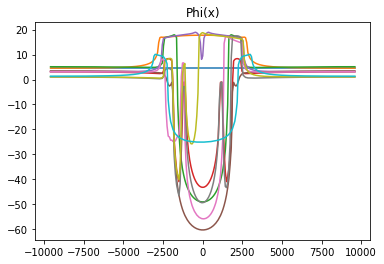

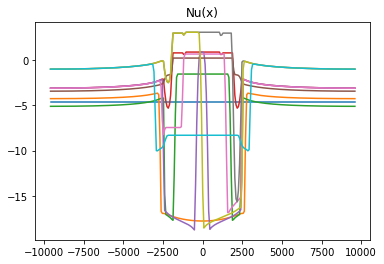

In [22]:
##Affichage
pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, Phi[n])
plt.title('Phi(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x, Nu[n])
plt.title('Nu(x)')
plt.show()

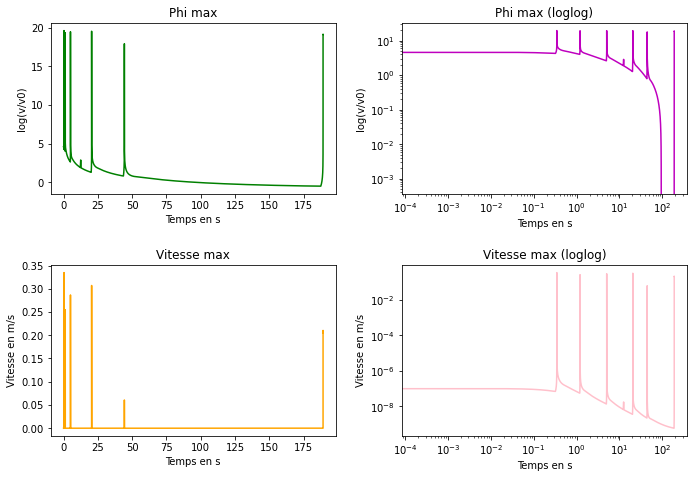

In [46]:
Mphi = np.array([np.max(f) for f in Phi])
Mv = np.array([np.max(f) for f in np.exp(Phi)])

fig = plt.figure(figsize=(10, 7))
    
ax = fig.add_subplot(2, 2, 1)
ax.plot(temps, Mphi, color='g')
ax.set_title('Phi max')
ax.set_xlabel('Temps en s')
ax.set_ylabel('log(v/v0)')

ax = fig.add_subplot(2, 2, 2)
ax.loglog(temps, Mphi, color='m')
ax.set_title('Phi max (loglog)')
ax.set_xlabel('Temps en s')
ax.set_ylabel('log(v/v0)')

ax = fig.add_subplot(2, 2, 3)
ax.plot(temps, Mv*v0, color='orange')
ax.set_title('Vitesse max')
ax.set_xlabel('Temps en s')
ax.set_ylabel('Vitesse en m/s')

ax = fig.add_subplot(2, 2, 4)
ax.loglog(temps, Mv*v0, color='pink')
ax.set_title('Vitesse max (loglog)')
ax.set_xlabel('Temps en s')
ax.set_ylabel('Vitesse en m/s')

fig.tight_layout(pad=2.0)